# Advanced Lane Finding

## Importing required packages

In [1]:
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
% matplotlib inline
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Camera Calibration

0. importing calibration images (chessboard images)
0. initiation of object and image points list
0. converting to grayscale
0. finding corners as imagepoints and appending object points (constant)
0. saving the resulting corner detection in an output folder over the original images
0. calibrate the opencv camera model using the object and image points
0. In order to test the model, we use the undistort function on a test image, not seen by calibration function, with the model gained above

In [2]:
# importing image address
chsbrd_cal_img_path = 'camera_cal'
chsbrd_output_img_path = 'camera_cal/out_put_corners'

cal_imgs = glob.glob(chsbrd_cal_img_path + '/calibration*.jpg')

# initiating object and image points list
obj_points = []
img_points = []
test_imgs_path = []

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

objp=np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)


number_of_images_with_well_found_corners = 0
for img_path in cal_imgs:
    # import image
    cal_img = mpimg.imread(img_path)
    # convert to grayscale
    cal_img_gray = cv2.cvtColor(cal_img,cv2.COLOR_RGB2GRAY)
    """
    if images are not good enough or you made them from your monitor screen you will habe a lot of noise
    in the images (because of nature of monitor refresh you will have some noises in white areas) you 
    may want to filter images from and use it (without prining the chess board). In this case use the
    following filter and uncomment it:
    """
#     gray_editted = cv2.blur(cal_img_gray,(10,10))
#     gray_editted = (gray_editted>110)*255
#     cal_img_gray = 255-np.uint8(gray_editted)    
    
    # find corners
    ret, corners = cv2.findChessboardCorners(cal_img_gray,(nx,ny))
    
    # finding the name of the imported file and save the image with the same name in the other directory
    img_file_name = img_path.split('/')[-1].split('.')[0]
    if ret is True:
        number_of_images_with_well_found_corners += 1
        img_points.append(corners)
        obj_points.append(objp)
        # draw the corners on images and save it
        output_img = cv2.drawChessboardCorners(cal_img,(nx,ny),corners,ret)
        mpimg.imsave(chsbrd_output_img_path+'/'+img_file_name , output_img)
    else:
        print ('Corners of image {} are not found.'.format(img_file_name))
        test_imgs_path.append(img_path)

print('OpenCV found the corners of {} images from {} images'.
      format(number_of_images_with_well_found_corners,len(cal_imgs)))

Corners of image calibration1 are not found.
Corners of image calibration4 are not found.
Corners of image calibration5 are not found.
OpenCV found the corners of 17 images from 20 images


Corners of some of the images are not found because all corners were not inside the image or they were very close to the border of image. We can use these images to test the model to undistort and transform the chessboard for our model test algoritm.

In [3]:
# Calibrating camera using the obtained corners:
print('Calibrating the model')
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, cal_img_gray.shape[::-1], None, None)
camera_to_save={"camera_matrix":mtx,"camera_distortion":dist}
pickle.dump( camera_to_save, open( "camera_model_param.p", "wb" ) )
print('Calibration is Done and camera Matrix & Distortion are saved')
print('Camera Matrix:', ' \n',mtx)
print('Distortion Parameters:', ' \n',dist)


Calibrating the model
Calibration is Done and camera Matrix & Distortion are saved
Camera Matrix:  
 [[  1.15777818e+03   0.00000000e+00   6.67113857e+02]
 [  0.00000000e+00   1.15282217e+03   3.86124583e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Distortion Parameters:  
 [[-0.24688507 -0.02373155 -0.00109831  0.00035107 -0.00259868]]


### Test the Calibration
0. demonstration of one of the images with found courners
0. undistorting and transforing the test images

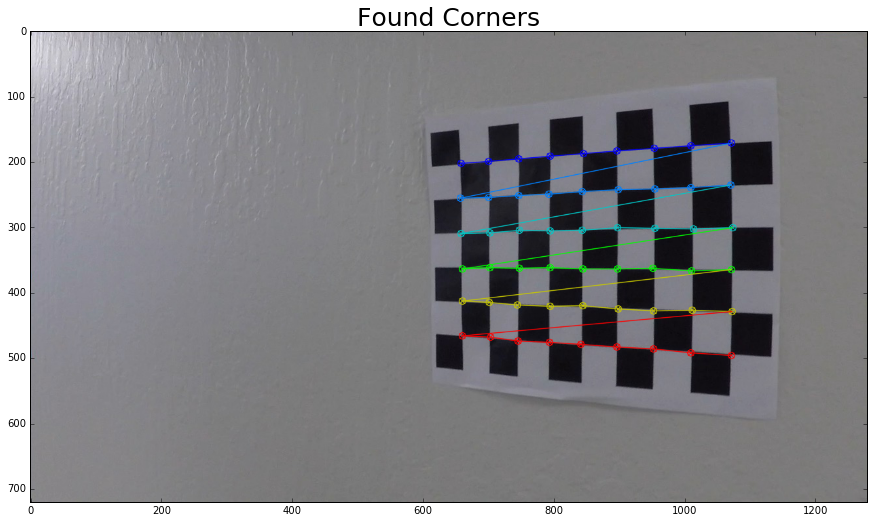

In [4]:
demo_img = mpimg.imread(chsbrd_output_img_path+'/calibration12')
plt.figure(figsize=(15,10))
plt.imshow(demo_img)
plt.title('Found Corners',fontsize=25)
plt.show()

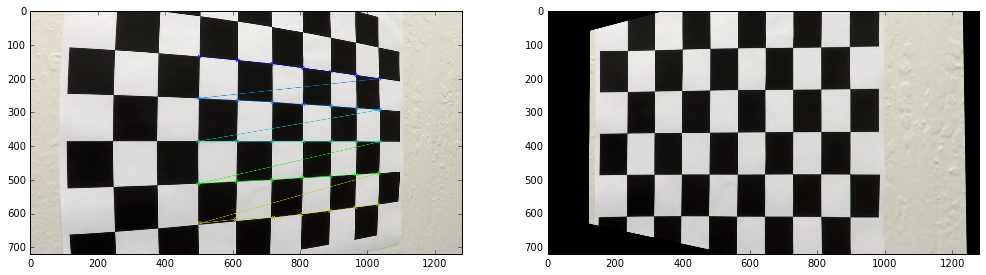

In [5]:
# undistoriting and transforming

def corners_unwarp(img_path, nx, ny,offsetx,offsety, mtx, dist):
    cal_img = mpimg.imread(img_path)
    heigth = cal_img.shape[0]
    width = cal_img.shape[1]
    # undistort image:
    img_undistorted = cv2.undistort(cal_img, mtx, dist, None, mtx)
    # convert to grayscale
    cal_img_gray = cv2.cvtColor(cal_img,cv2.COLOR_RGB2GRAY)
    # by changing these numbers, the opencv will find some on test images
    ret, corners = cv2.findChessboardCorners(cal_img_gray,(nx,ny),None)
    if ret is True:
        output_img_with_corners = cv2.drawChessboardCorners(cal_img,(nx,ny),corners,ret)
        src = np.float32([
            np.squeeze(corners[0]),
            np.squeeze(corners[nx-1]),
            np.squeeze(corners[nx*(ny-1)]),
            np.squeeze(corners[nx*ny-1])
            ])
        dst = np.float32([
            [offsetx,offsety],
            [width-offsetx,offsety],
            [offsetx,heigth-offsety],
            [width-offsetx,heigth-offsety]
        ])
        M = cv2.getPerspectiveTransform(src,dst)
        img_size = (width,heigth)
        warped = cv2.warpPerspective(img_undistorted, M, img_size, flags=cv2.INTER_LINEAR)
        plt.figure(figsize=(17,8))
        plt.subplot(121)
        plt.imshow(output_img_with_corners)
        plt.subplot(122)
        plt.imshow(warped)
        plt.show()

for img_path in test_imgs_path:
    corners_unwarp(img_path, nx-2, ny-1,400,120, mtx, dist)

<a name="abcd"></a>
## Main pipline:
Now having the calibrated model of image, a pipeline should be design that is working for at least one frame and then later will be applied for a video. The pipeline should include:
0. Camera Calibration (which is done above)
0. Distortion correction on road image
0. Perspective Transform to get a bird-eye view of the road (simply top view of the road)
0. Color and Gradient thresholing to find a rough place of lanes (The order of this and previous can be changed)
0. Fine tunning the previous methof using the sliding window and histogram
0. Find curvature equation

In [2]:
def get_camera_para ():
    """
    loads the camera model parameter and returns two arrays
    camera matrix and camera distortion parameters
    """
    camera_model = pickle.load( open( "camera_model_param.p", "rb" ) )
    return camera_model["camera_matrix"],camera_model["camera_distortion"]


def undistor_img(img, mtx, dist):
    img_undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return img_undistorted

(720, 1280, 3)


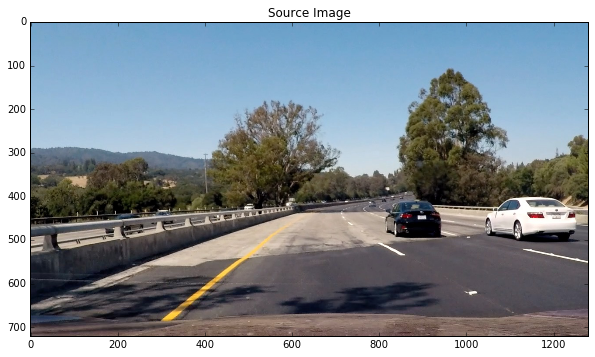

In [3]:
test_imgs_path_folder = 'test_images'
test_imgs_path = glob.glob(test_imgs_path_folder+'/*.jpg',)
difficult_imgs = glob.glob(test_imgs_path_folder+'/problem*.jpg',)
mtx,dist = get_camera_para()
test_img_idx = 5
test_img = mpimg.imread(test_imgs_path[test_img_idx])
print(test_img.shape)

plt.figure(figsize=(10,8))
plt.imshow(test_img)
plt.title('Source Image')
plt.show()

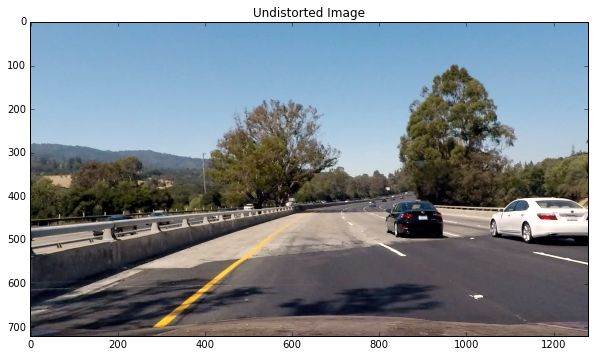

In [4]:
# undistort image
img_undistorted = undistor_img(test_img,mtx,dist)
plt.figure(figsize=(10,8))
plt.imshow(img_undistorted)
plt.title('Undistorted Image')
plt.show()

## Transformation

In [5]:
# transformation
# src = np.float32([[213,705],[1074,692],[667,435],[614,435]])
# dst_small = np.float32([[213,705],[1074,692],[1076,0],[213,0]])
# src line equation for transformation
left_points_x = np.float32([213,617]) # [213,614]
left_points_y = np.float32([705,435])

right_points_x = np.float32([1074,662]) # [1074,667]
right_points_y = np.float32([692,435])

left_line_trans = np.polyfit(left_points_y,left_points_x,1)
right_line_trans = np.polyfit(right_points_y,right_points_x,1)

src_size = (test_img.shape[1],test_img.shape[0])
dst_size = (int(test_img.shape[1]*1.2),int(test_img.shape[0]))

Source points:
[[  213.           705.        ]
 [ 1094.8404541    705.        ]
 [  686.04669189   450.        ]
 [  594.55554199   450.        ]]
Destination points:
[[  341.          705.       ]
 [ 1222.8404541   705.       ]
 [ 1222.8404541     0.       ]
 [  341.            0.       ]]


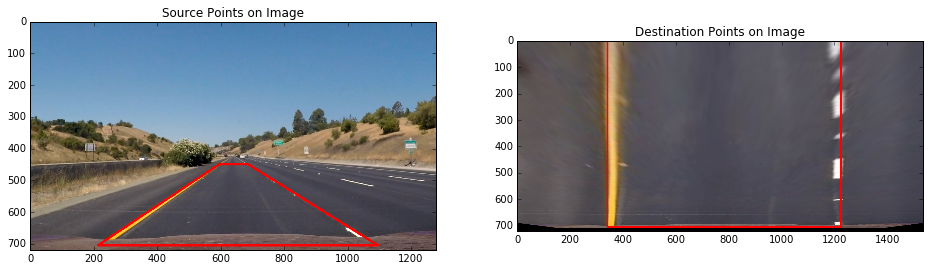

In [6]:
# transformation
def get_transform_matrices(left_line_trans,right_line_trans,src_size,dst_size):
    mid_x_src = src_size[0] / 2
    mid_x_dst = dst_size[0] / 2

    y2 = 705
    y1 = 450 # 460
    src = np.float32([[np.polyval(left_line_trans,y2),y2],
                      [np.polyval(right_line_trans,y2),y2],
                      [np.polyval(right_line_trans,y1),y1],
                      [np.polyval(left_line_trans,y1),y1]])

    dst=np.float32([[mid_x_dst - (mid_x_src - src[0,0]) , dst_size[1]-(src_size[1]-src[0,1])],
         [mid_x_dst - (mid_x_src - src[1,0]) , dst_size[1]-(src_size[1]-src[1,1])],
         [mid_x_dst - (mid_x_src - src[1,0]) , dst_size[1]-(src_size[1]-0)],
         [mid_x_dst - (mid_x_src - src[0,0]) , dst_size[1]-(src_size[1]-0)]])
    M = cv2.getPerspectiveTransform(src,dst)
    M_inv = cv2.getPerspectiveTransform(dst,src)
    return M,M_inv,[src,dst] # src is required for drawing the polygon to transform

# warped = cv2.warpPerspective(img_undistorted, M, dst_size, flags=cv2.INTER_LINEAR)

def draw_transform_polygon(img,src_points):
    img_with_polygon = img.copy()
    cv2.polylines(img_with_polygon, np.int32([src_points]),True,[255,0,0],5)
    return img_with_polygon

M,_,ploygon_pts = get_transform_matrices(left_line_trans,right_line_trans,src_size,dst_size)
test_img = mpimg.imread(test_imgs_path[0])
transformed_test_img = cv2.warpPerspective(test_img, M, dst_size, flags=cv2.INTER_LINEAR)
print('Source points:')
print(ploygon_pts[0])
print('Destination points:')
print(ploygon_pts[1])
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.title('Source Points on Image')
plt.imshow(draw_transform_polygon(test_img,ploygon_pts[0]))
plt.subplot(122)
plt.title('Destination Points on Image')
plt.imshow(draw_transform_polygon(transformed_test_img,ploygon_pts[1]))
plt.show()

## Thresholding

In [7]:
def thresholding (arr,thresh):
    """
    General thresholding
    """
    binary_out = np.zeros_like(arr)
    binary_out[(arr>=thresh[0])&(arr<=thresh[1])]=1
    return binary_out

def scaling(arr):
    arr_scaled = np.uint8(255.0*arr/np.max(arr))
    return arr_scaled

def abs_sobel_thresh(channel,sobel_kernel = 3, orient='x', thresh=(0,255)):
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient is 'x':
        sobel_img = cv2.Sobel(channel, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    else:
        sobel_img = cv2.Sobel(channel, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # Take the absolute value of the derivative or gradient
    sobel_abs = np.absolute(sobel_img)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    sobel_scaled = scaling(sobel_abs)
    # Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    binary_img = thresholding(sobel_scaled,thresh)
    # 6) Return this mask as your binary_output image
    return binary_img,sobel_scaled

def mag_sobel_thresh(channel, sobel_kernel=3, thresh=(0, 255)):
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(channel, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # Calculate the magnitude 
    abs_sobel = np.sqrt(np.power(sobelx,2)+np.power(sobely,2))
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = scaling(abs_sobel)
    # Create a binary mask where mag thresholds are met
    binary_img = thresholding(scaled_sobel,thresh)
    # Return this mask as your binary_output image
    return binary_img,scaled_sobel

def dir_sobel_thresh(channel, sobel_kernel=3, thresh=(-np.pi/2, np.pi/2)):
    #  Take the gradient in x and y separately
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(channel, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.sqrt(np.power(sobelx,2))
    abs_sobely = np.sqrt(np.power(sobely,2))
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    angle = np.arctan2(abs_sobely, abs_sobelx)
    angle = np.absolute(angle)
    angle = scaling(angle)
    # Create a binary mask where direction thresholds are met
    binary_output = thresholding(angle,thresh)
    # Return this mask as your binary_output image
    return binary_output,angle

def grad_thresholding (warped_image,
                       s_channel_thresh =(160,255) ,
                       sobel_x_thresh=(30,255),
                       sobel_mag_thresh=(30, 255),
                       dir_thresh=(0,150),
                       ksize = 3):
    
    hls_img = cv2.cvtColor(warped_image,cv2.COLOR_RGB2HLS)
    #l_channel = hls_img[:,:,1]
    s_channel = hls_img[:,:,2]
    channel = s_channel
    #channel test
    #channel=scaling(channel)
    channel=s_channel
    channel_bin = thresholding(channel,thresh=s_channel_thresh)
    #sobell test
    sobel_x_bin,sobel_x = abs_sobel_thresh(channel, sobel_kernel=ksize,orient='x',thresh=sobel_x_thresh)
    # sobel mag test
    sobel_mag_bin,sobel_mag = mag_sobel_thresh(channel, sobel_kernel=ksize,thresh=sobel_mag_thresh )
    # dir test
    sobel_dir_bin,sobel_dir = dir_sobel_thresh(channel, sobel_kernel=ksize,thresh=dir_thresh )
    # combine
    combined_image = np.uint8(np.logical_and(sobel_mag_bin,channel_bin))
    return channel_bin,sobel_x_bin, sobel_mag_bin, sobel_dir_bin, combined_image

def grad_thresholding1 (warped_image,
                       s_channel_thresh =(160,255) ,
                       sobel_mag_thresh=(30, 255),
                       ksize = 3):
    
    hls_img = cv2.cvtColor(warped_image,cv2.COLOR_RGB2HLS)
    #l_channel = hls_img[:,:,1]
    s_channel = hls_img[:,:,2]
    channel = s_channel
    #channel test
    #channel=scaling(channel)
    channel=s_channel
    channel_bin = thresholding(channel,thresh=s_channel_thresh)
    # sobel mag test
    sobel_mag_bin,sobel_mag = mag_sobel_thresh(channel, sobel_kernel=ksize,thresh=sobel_mag_thresh )
    # combine
    combined_image = np.uint8(np.logical_and(sobel_mag_bin,channel_bin))
    return combined_image

## Practice on Thresholding functions

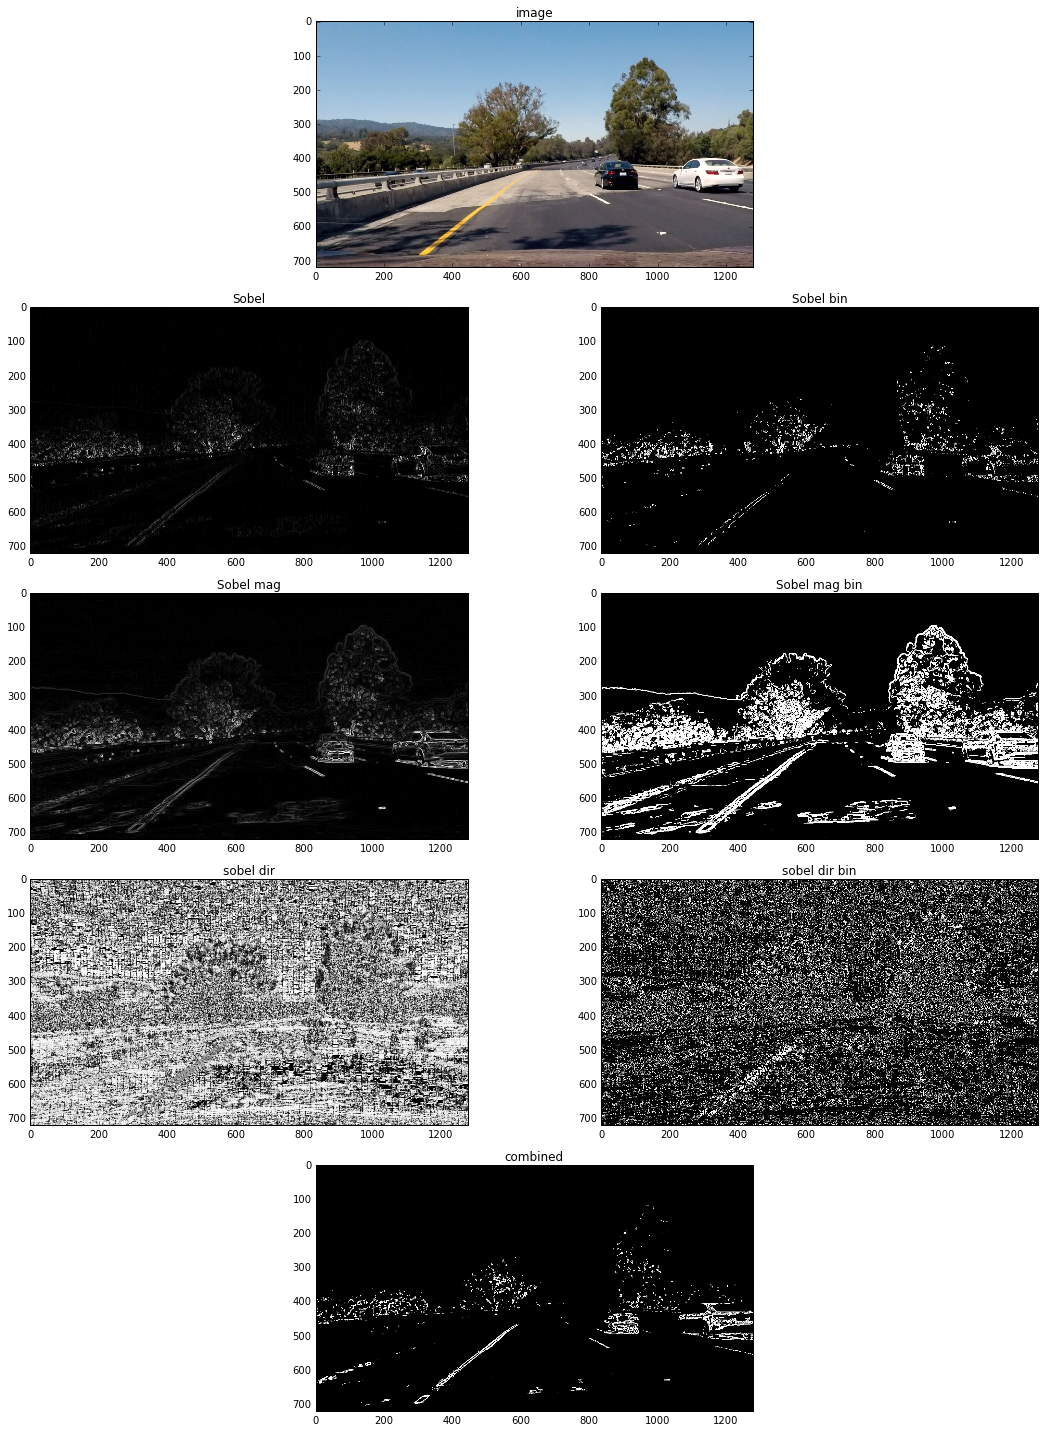

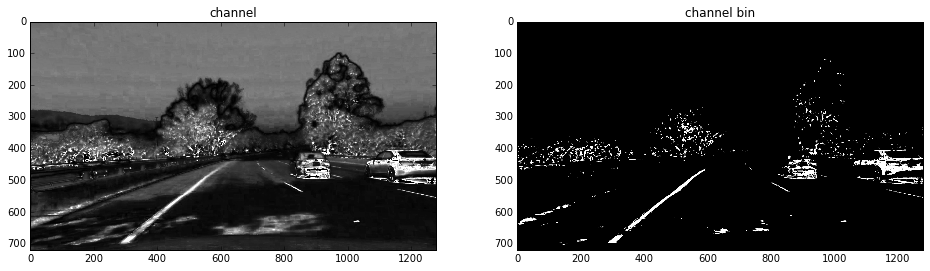

In [8]:
# conda install pyqt=4
# inline
# %matplotlib inline 
test_img = mpimg.imread(test_imgs_path[5])# test_imgs_path difficult_imgs
M, M_inv,_ = get_transform_matrices(left_line_trans,right_line_trans,src_size,dst_size)
#undistort
img_undistorted = undistor_img(test_img,mtx,dist)
warped = cv2.warpPerspective(img_undistorted, M, dst_size, flags=cv2.INTER_NEAREST)#INTER_LINEAR
# exctract S channel
hls_img = cv2.cvtColor(img_undistorted,cv2.COLOR_RGB2HLS)
l_channel = hls_img[:,:,1]
s_channel = hls_img[:,:,2]#2
channel = s_channel
# channel = scaling(s_channel)
#s_channel test
channel_bin = thresholding(channel,thresh=(150,255))
# print(np.max(channel))
#sobell test
sobel_x_bin,sobel_x = abs_sobel_thresh(channel, sobel_kernel=3,orient='x',thresh=(50,255))
# print(np.min(sobel_x),np.max(sobel_x))
# sobel mag test
sobel_mag_bin,sobel_mag = mag_sobel_thresh(channel, sobel_kernel=5,thresh=(20, 255) )
# dir test
sobel_dir_bin,sobel_dir = dir_sobel_thresh(channel, sobel_kernel=5,thresh=(80,150) )
# combine
combined_image = np.uint8(np.logical_and(channel_bin,sobel_mag_bin))

plt.figure(figsize=(16,20))
plt.subplot(511)
plt.imshow(test_img)
plt.title('image')
plt.subplot(523)
plt.imshow(sobel_x,cmap='gray')
plt.title('Sobel')
plt.subplot(524)
plt.imshow(sobel_x_bin,cmap='gray')
plt.title('Sobel bin')
plt.subplot(525)
plt.imshow(sobel_mag,cmap='gray')
plt.title('Sobel mag')
plt.subplot(526)
plt.imshow(sobel_mag_bin,cmap='gray')
plt.title('Sobel mag bin')
plt.subplot(527)
plt.imshow(sobel_dir,cmap='gray')
plt.title('sobel dir')
plt.subplot(528)
plt.imshow(sobel_dir_bin,cmap='gray')
plt.title('sobel dir bin')
plt.subplot(515)
plt.imshow(combined_image,cmap='gray')
plt.title('combined')
plt.tight_layout()
plt.figure(figsize=(16,16))
plt.subplot(121)
plt.imshow(channel,cmap='gray')
plt.title('channel')
plt.subplot(122)
plt.imshow(channel_bin,cmap='gray')
plt.title('channel bin')
plt.show()

## Lane-line Pixel Detection

In [97]:
def histogram_peak_detection(img):
    histo = np.sum(img[int(img.shape[0]*2/5):,:], axis=0)
    mid_point = int(histo.shape[0]/2)
    left_peak = np.argmax(histo[:mid_point])
    right_peak = np.argmax(histo[mid_point:]) + mid_point
    return histo,left_peak,right_peak

def mask2rgb(binary_warped):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    return out_img

def get_nonzero_idx(binary_warped):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    return nonzerox,nonzeroy

def get_left_right_line_pxl_pos(nonzerox,nonzeroy,left_lane_inds,right_lane_inds):
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx,lefty,rightx,righty

def find_lane_from_histogram(binary_warped,leftx_base,rightx_base):
    # sliding windows
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Identify the x and y positions of all nonzero pixels in the image
    nonzerox,nonzeroy = get_nonzero_idx(binary_warped)
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) &
                          (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) &
                          (nonzerox < win_xleft_high)).nonzero()[0]

        good_right_inds = ((nonzeroy >= win_y_low) &
                           (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) &
                           (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx,lefty,rightx,righty=get_left_right_line_pxl_pos(nonzerox,nonzeroy,left_lane_inds,right_lane_inds)
    # Fit a second order polynomial to each
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    except:
        return False, 0,0,0
    
    lane_inds = (left_lane_inds,right_lane_inds)
    lane_fit = (left_fit,right_fit)
    return True,out_img,lane_inds,lane_fit

# Generate x and y values for plotting
def generate_x_y_for_ploting(binary_warped,lane_fit):
    left_fit = lane_fit[0]
    right_fit = lane_fit[1]
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    lane_fits_pts = (left_fitx,right_fitx,ploty)
    return lane_fits_pts

def fill_between_lines(warped_img, lane_fit):
    left_fit =lane_fit[0]
    right_fit =lane_fit[1]
    warped_result = np.zeros((warped_img.shape[0],warped_img.shape[1],3),dtype=np.uint8)
    
    for indy in range(warped_img.shape[0]):
        left_lim = np.uint(np.polyval(left_fit,indy))
        left_lim = max(left_lim,0)
        right_lim = np.uint(np.polyval(right_fit,indy))
        right_lim = min(right_lim,warped_img.shape[1]-1)
        for idx in range (left_lim,right_lim):
            warped_result[indy,idx,:]=[0,255,0]#green
    return warped_result

# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def find_lane_from_pre_frame(binary_warped,lane_fit,margin=100):
    left_fit =lane_fit[0]
    right_fit =lane_fit[1] 
    nonzerox,nonzeroy = get_nonzero_idx(binary_warped)
    margin = 100
    left_lane_inds = (
        (nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) &
        (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = (
        (nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) &
        (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    # Again, extract left and right line pixel positions
    leftx,lefty,rightx,righty=get_left_right_line_pxl_pos(nonzerox,nonzeroy,left_lane_inds,right_lane_inds)    
    # Fit a second order polynomial to each
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    except:
        return False, 0,0
    lane_inds = (left_lane_inds,right_lane_inds)
    lane_fit = (left_fit,right_fit)
    return True,lane_inds,lane_fit

# Create an image to draw on and an image to show the selection window
def visualize_selected_curvy_window(binary_warped, lane_inds,lane_fits_pts,margin=100):
    left_lane_inds = lane_inds[0]
    right_lane_inds = lane_inds[1]
    
    left_fitx = lane_fits_pts[0]
    right_fitx = lane_fits_pts[1]
    ploty = lane_fits_pts[2]
    
    out_img = mask2rgb(binary_warped)
    window_img = np.zeros_like(out_img)
    nonzerox,nonzeroy = get_nonzero_idx(binary_warped)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    try:
        result [ploty.astype(int),left_fitx.astype(int), :]=[255,255,0] #yellow
        result [ploty.astype(int),right_fitx.astype(int), :]=[255,255,0] #yellow
    except:
        pass
    return result

def visualise_only_curves(binary_warped,lane_fits_pts,margin=20):  
    left_fitx = lane_fits_pts[0]
    right_fitx = lane_fits_pts[1]
    ploty = lane_fits_pts[2]
    
    out_img = np.zeros((binary_warped.shape[0],binary_warped.shape[1],3),dtype=np.uint8)
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(out_img, np.int_([left_line_pts]), (255,0, 0))
    cv2.fillPoly(out_img, np.int_([right_line_pts]), (0,0, 255))
    return out_img

def stack_images(img1,img2,img3,img4):
    width = img1.shape[1]
    
    img4 = cv2.resize(img4,None,
                      fx=width/3/img4.shape[1],fy=width/3/img4.shape[1])
    img2 = cv2.resize(img2,(img4.shape[1],img4.shape[0]))
    img3 = cv2.resize(img3,(img4.shape[1],img4.shape[0]))
    down_image = np.concatenate((img2,img3),axis=1)
    down_image = np.concatenate((down_image,img4),axis=1)
    down_image = cv2.resize(down_image,None,
                            fx=width/down_image.shape[1],fy=width/down_image.shape[1])
    result = np.uint8(np.concatenate((img1,down_image),axis=0))
    return result


def find_road_curv_car_pos(lane_fit, y ,img_width):
    left = lane_fit[0]
    right = lane_fit[1]
    left_r = (1 + (2*left[0]*y+left[1])**2)**(3/2)/abs(2*left[0])
    right_r = (1 + (2*right[0]*y+right[1])**2)**(3/2)/abs(2*right[0])
    gain_pix2dis =  3.7/(np.polyval(right,y)-np.polyval(left,y))
    dev_from_center = (np.polyval(right,y)+np.polyval(left,y))/2 - img_width/2
    dev_from_center *= gain_pix2dis 
    return (left_r+right_r)/2,dev_from_center

def check_two_lines(lane_fit):
    left = lane_fit[0]
    right = lane_fit[1]
    y = 0
    return np.polyval(right,y)-np.polyval(left,y)>400

def filter_base_on_previous_frames(lane_fit):
    global buffer_lines,num_bad_detect_in_row
    global lines_idx, number_of_full
    if number_of_full > 0:
        differece = buffer_lines[lines_idx-1]-np.array(lane_fit)
        differece = np.linalg.norm(differece)
        print (differece)
        if (differece>150.0 and num_bad_detect_in_row<8): #and is_previous_difference_not_ok==False
            num_bad_detect_in_row += 1
            average = np.mean(buffer_lines[:number_of_full,:,:],axis=0)
            return average.tolist(),False        
    num_bad_detect_in_row = 0
    buffer_lines[lines_idx]=np.array(lane_fit)
    lines_idx+=1
    number_of_full +=1
    if lines_idx>= 20:
        lines_idx = 0
    if number_of_full>= 20:
        number_of_full = 20
    average = np.mean(buffer_lines[:number_of_full,:,:],axis=0)
    return average.tolist(),True

In [98]:
M, M_inv,_ = get_transform_matrices(left_line_trans,right_line_trans,src_size,dst_size)

buffer_lines = np.zeros((20,2,3),dtype=np.float) # 15 frames to average
lines_idx = 0
number_of_full = 0
num_bad_detect_in_row = 0

def find_lanes(img,do_average=True):
    global is_detected
    global lane_inds,lane_fit,lane_fits_pts
    is_detected = False
    img_undistorted = undistor_img(img,mtx,dist)
    combined_image1  = grad_thresholding1 (img_undistorted,
                       s_channel_thresh =(70,255) ,
                       sobel_mag_thresh=(30, 255), # 15
                       ksize = 7)
    warped1 = cv2.warpPerspective(combined_image1, M, dst_size, flags=cv2.INTER_LINEAR)
    warped2 = cv2.warpPerspective(img_undistorted, M, dst_size, flags=cv2.INTER_LINEAR)
    hls_img = cv2.cvtColor(warped2,cv2.COLOR_RGB2HLS)
    s_channel = hls_img[:,:,2]
    sobel_x2,_ = abs_sobel_thresh(s_channel,sobel_kernel=15, orient='x', thresh=(30, 255))
    binary_warped = np.zeros_like(sobel_x2)
    heigth_brd = int(binary_warped.shape[0]/3)
    binary_warped[:heigth_brd,:] = warped1[:heigth_brd,:]
    binary_warped[heigth_brd:,:] = sobel_x2[heigth_brd:,:]
#     binary_warped [690:,:] = 0 # cut a few of the image
    if is_detected is False:
        hist,le,ri = histogram_peak_detection(binary_warped)
        is_detected,out_img,lane_inds,lane_fit = find_lane_from_histogram(binary_warped,le,ri)
    else:
        is_detected ,lane_inds,lane_fit = find_lane_from_pre_frame(binary_warped,lane_fit)
        if is_detected == True:
            is_detected = check_two_lines(lane_fit)
            if is_detected == True:
                lane_fits_pts = generate_x_y_for_ploting(binary_warped,lane_fit)
                out_img = visualize_selected_curvy_window(binary_warped,lane_inds,lane_fits_pts,margin=100)
        if is_detected == False:
            hist,le,ri = histogram_peak_detection(binary_warped)
            is_detected,out_img,lane_inds,lane_fit = find_lane_from_histogram(binary_warped,le,ri)
    if is_detected == False:
        out_img = mask2rgb(binary_warped)
        result = stack_images(img,mask2rgb(warped1),mask2rgb(sobel_x2),out_img)
    else:
        if (do_average):
            lane_fit,difference_is_ok = filter_base_on_previous_frames(lane_fit)
#         lane_fits_pts = generate_x_y_for_ploting(binary_warped,lane_fit)
#         only_curves=visualise_only_curves(binary_warped,lane_fits_pts,margin=20)
#         only_curves = cv2.warpPerspective(only_curves, M_inv, src_size, flags=cv2.INTER_LINEAR)
        only_curves = fill_between_lines(binary_warped, lane_fit)
        only_curves = cv2.warpPerspective(only_curves, M_inv, src_size, flags=cv2.INTER_LINEAR)
        out_img2 = cv2.addWeighted(img, 1, only_curves, 0.3, 0)
        result = stack_images(out_img2,mask2rgb(warped1),mask2rgb(sobel_x2),out_img)
        radius,deviation = find_road_curv_car_pos(lane_fit,binary_warped.shape[0]-100,binary_warped.shape[1])
        text = 'The radius of curvature: {:.3} meters'.format(radius)
        cv2.putText(result,text,(20,50),cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255) , 2 ,cv2.LINE_AA)
        text = 'Deviation From Center of the lane: {:.3} meters'.format(deviation)
        cv2.putText(result,text,(20,100),cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255) , 2 ,cv2.LINE_AA)

    return result

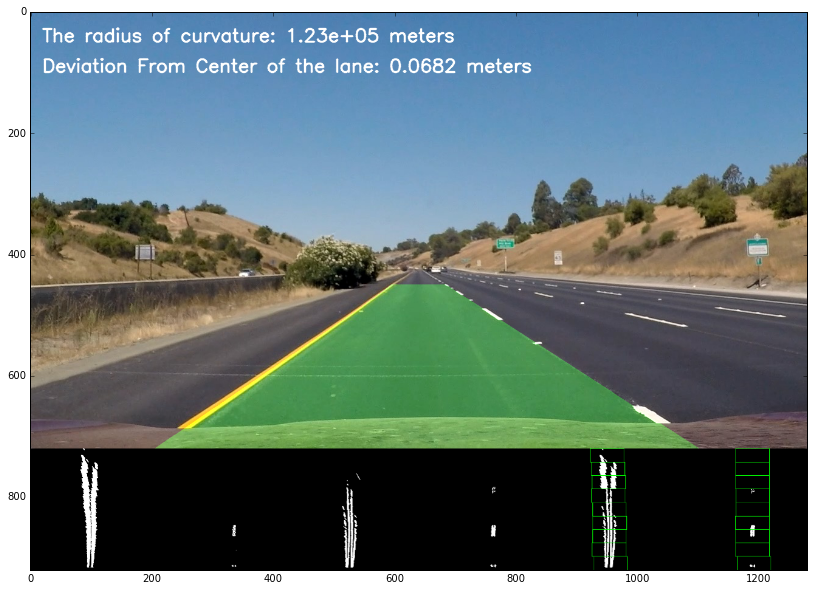

73.4123885859


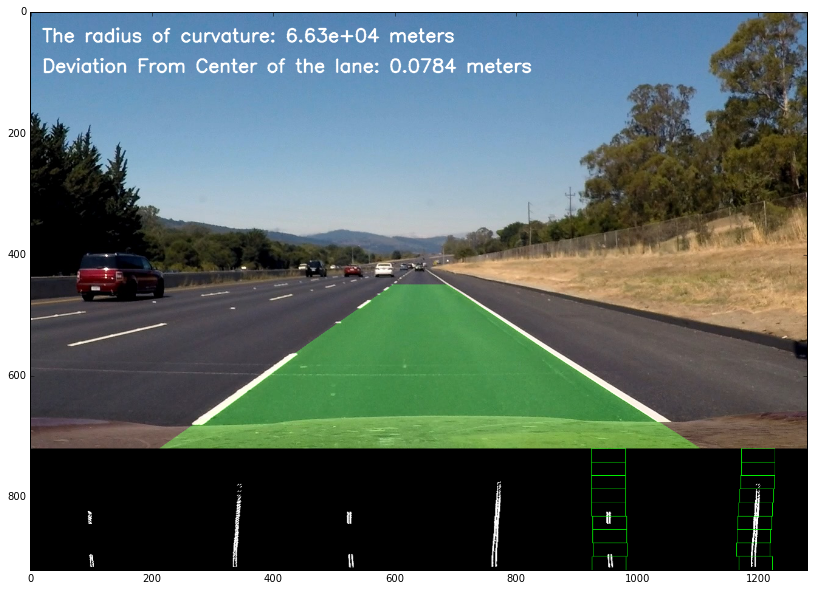

308.401359193


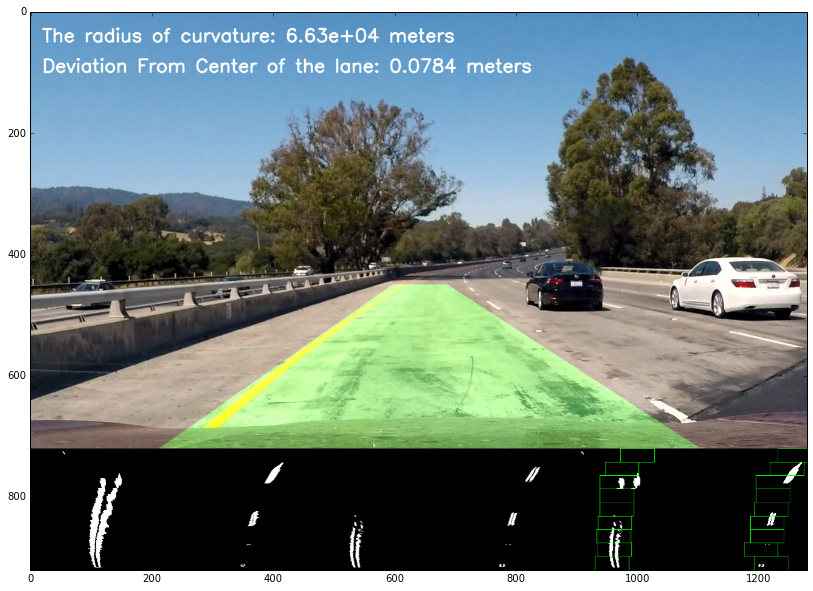

293.179742329


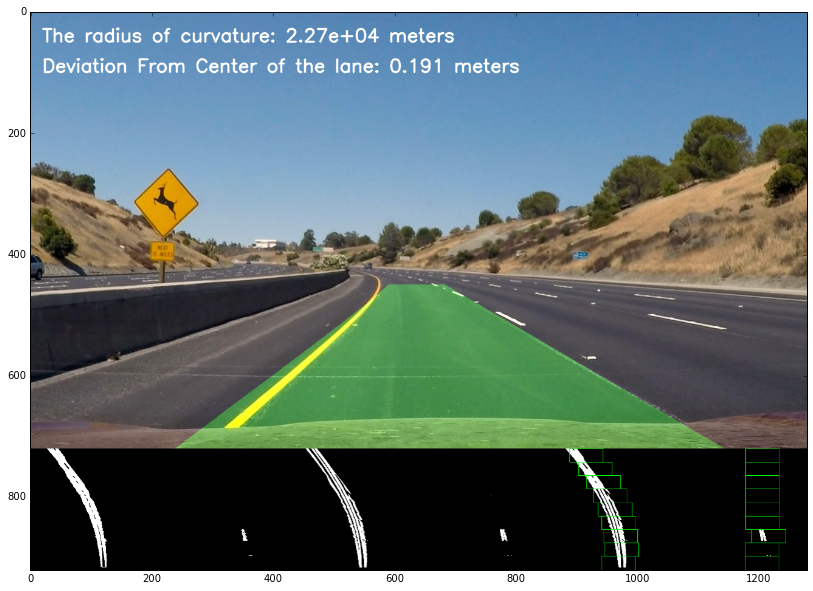

684.332351852


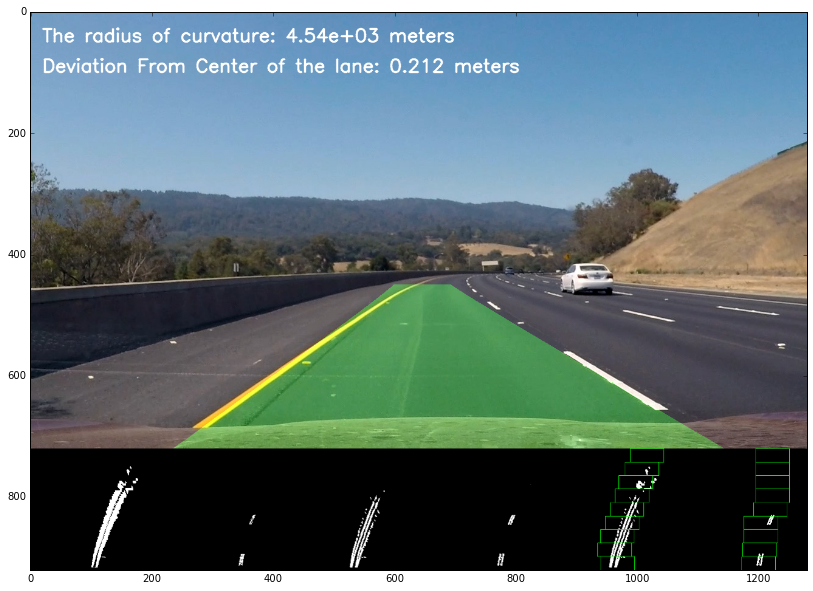

46.0091455454


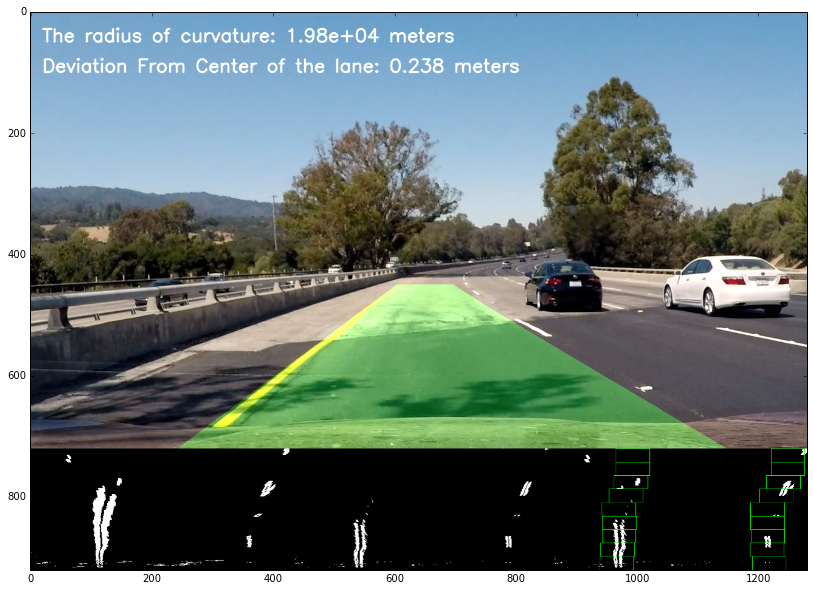

240.198820439


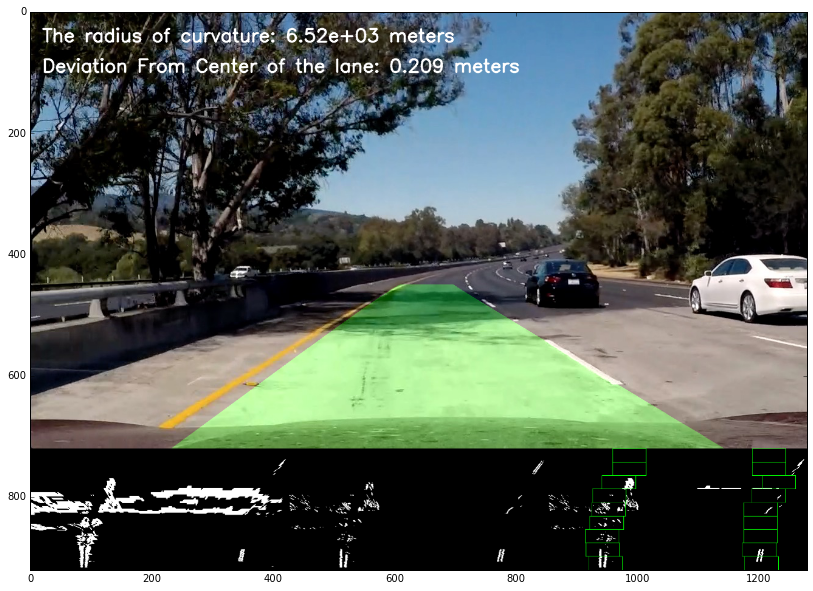

274.296762409


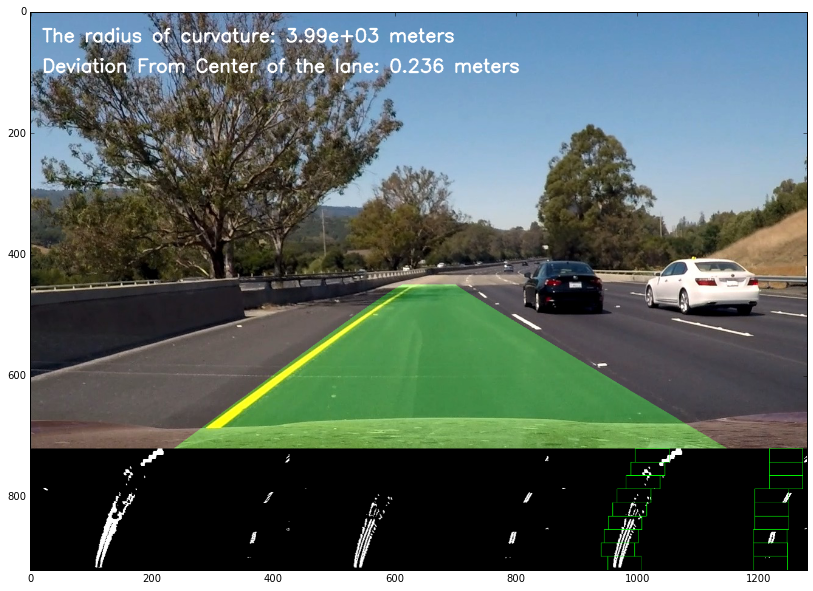

In [78]:
is_detected = False
for img_path in test_imgs_path: # test_imgs_path
    is_detected = False
    input_img = mpimg.imread(img_path)
    out = find_lanes(input_img,do_average=True)
    plt.figure(figsize=(16,10))
    plt.imshow(out)
    plt.show()

In [100]:
# init global functions
num_bad_detect_in_row = 0
is_detected = False
buffer_lines = np.zeros((20,2,3),dtype=np.float) # 15 frames to average
lines_idx = 0
number_of_full = 0

output = 'out.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(find_lanes) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video out.mp4
[MoviePy] Writing video out.mp4






  0%|          | 0/1261 [00:00<?, ?it/s]

0.0






  0%|          | 1/1261 [00:01<27:58,  1.33s/it]

32.7872418741






  0%|          | 2/1261 [00:02<27:47,  1.32s/it]

2.10536645837






  0%|          | 3/1261 [00:03<27:36,  1.32s/it]

4.51403078579






  0%|          | 4/1261 [00:05<27:43,  1.32s/it]

23.7246895946






  0%|          | 5/1261 [00:06<27:36,  1.32s/it]

7.69295025658






  0%|          | 6/1261 [00:07<27:26,  1.31s/it]

32.0616788682






  1%|          | 7/1261 [00:09<27:19,  1.31s/it]

50.3578110624






  1%|          | 8/1261 [00:10<27:16,  1.31s/it]

5.35303435115






  1%|          | 9/1261 [00:11<27:15,  1.31s/it]

12.2713672249






  1%|          | 10/1261 [00:13<27:14,  1.31s/it]

23.9186285762






  1%|          | 11/1261 [00:14<27:03,  1.30s/it]

38.7557966381






  1%|          | 12/1261 [00:15<27:04,  1.30s/it]

26.572964357






  1%|          | 13/1261 [00:16<27:06,  1.30s/it]

8.1893232574






  1%|          | 14/1261 [00:18<27:03,  1.30s/it]

21.8942322538






  1%|          | 15/1261 [00:19<27:02,  1.30s/it]

26.4186481465






  1%|▏         | 16/1261 [00:20<26:54,  1.30s/it]

8.5695972831






  1%|▏         | 17/1261 [00:22<26:56,  1.30s/it]

29.5943492217






  1%|▏         | 18/1261 [00:23<27:07,  1.31s/it]

59.3985490465






  2%|▏         | 19/1261 [00:24<27:05,  1.31s/it]

7.48149978512






  2%|▏         | 20/1261 [00:26<27:02,  1.31s/it]

242.111909823






  2%|▏         | 21/1261 [00:27<27:01,  1.31s/it]

240.72148139






  2%|▏         | 22/1261 [00:28<26:58,  1.31s/it]

349.486115163






  2%|▏         | 23/1261 [00:30<26:51,  1.30s/it]

278.978109937






  2%|▏         | 24/1261 [00:31<26:45,  1.30s/it]

95.2310806162






  2%|▏         | 25/1261 [00:32<26:38,  1.29s/it]

117.99291767






  2%|▏         | 26/1261 [00:33<26:34,  1.29s/it]

7.25064658106






  2%|▏         | 27/1261 [00:35<26:31,  1.29s/it]

18.3623640366






  2%|▏         | 28/1261 [00:36<26:31,  1.29s/it]

8.25412478941






  2%|▏         | 29/1261 [00:37<26:33,  1.29s/it]

31.6837577433






  2%|▏         | 30/1261 [00:39<26:31,  1.29s/it]

14.1319636037






  2%|▏         | 31/1261 [00:40<26:34,  1.30s/it]

36.1842323814






  3%|▎         | 32/1261 [00:41<26:36,  1.30s/it]

70.564712617






  3%|▎         | 33/1261 [00:42<26:31,  1.30s/it]

18.869148001






  3%|▎         | 34/1261 [00:44<26:26,  1.29s/it]

12.2911475751






  3%|▎         | 35/1261 [00:45<26:33,  1.30s/it]

4.58897779528






  3%|▎         | 36/1261 [00:46<26:33,  1.30s/it]

22.2787373449






  3%|▎         | 37/1261 [00:48<26:36,  1.30s/it]

45.6486940074






  3%|▎         | 38/1261 [00:49<26:37,  1.31s/it]

9.81577367399






  3%|▎         | 39/1261 [00:50<26:27,  1.30s/it]

12.5055166806






  3%|▎         | 40/1261 [00:52<26:16,  1.29s/it]

5.29356866542






  3%|▎         | 41/1261 [00:53<26:12,  1.29s/it]

15.3421929734






  3%|▎         | 42/1261 [00:54<26:07,  1.29s/it]

9.30585372573






  3%|▎         | 43/1261 [00:55<26:07,  1.29s/it]

5.05687455425






  3%|▎         | 44/1261 [00:57<26:08,  1.29s/it]

8.32064729778






  4%|▎         | 45/1261 [00:58<26:06,  1.29s/it]

186.404162043






  4%|▎         | 46/1261 [00:59<26:05,  1.29s/it]

226.235877576






  4%|▎         | 47/1261 [01:01<25:58,  1.28s/it]

218.324406773






  4%|▍         | 48/1261 [01:02<25:57,  1.28s/it]

232.714937668






  4%|▍         | 49/1261 [01:03<25:52,  1.28s/it]

56.097363467






  4%|▍         | 50/1261 [01:04<26:03,  1.29s/it]

28.0770705958






  4%|▍         | 51/1261 [01:06<26:05,  1.29s/it]

42.3601229778






  4%|▍         | 52/1261 [01:07<26:03,  1.29s/it]

6.77521407643






  4%|▍         | 53/1261 [01:08<26:00,  1.29s/it]

16.588022811






  4%|▍         | 54/1261 [01:10<26:00,  1.29s/it]

11.0540768432






  4%|▍         | 55/1261 [01:11<26:01,  1.29s/it]

16.4020921253






  4%|▍         | 56/1261 [01:12<26:00,  1.30s/it]

14.5106859045






  5%|▍         | 57/1261 [01:13<25:59,  1.29s/it]

13.8324674353






  5%|▍         | 58/1261 [01:15<25:51,  1.29s/it]

130.685183648






  5%|▍         | 59/1261 [01:16<25:56,  1.29s/it]

29.2977079957






  5%|▍         | 60/1261 [01:17<25:51,  1.29s/it]

61.3392715227






  5%|▍         | 61/1261 [01:19<25:45,  1.29s/it]

11.347113315






  5%|▍         | 62/1261 [01:20<25:38,  1.28s/it]

11.6872248211






  5%|▍         | 63/1261 [01:21<25:35,  1.28s/it]

53.5047890688






  5%|▌         | 64/1261 [01:22<25:29,  1.28s/it]

36.3217849516






  5%|▌         | 65/1261 [01:24<25:20,  1.27s/it]

9.29262910273






  5%|▌         | 66/1261 [01:25<25:20,  1.27s/it]

8.01530674309






  5%|▌         | 67/1261 [01:26<25:18,  1.27s/it]

56.6486293663






  5%|▌         | 68/1261 [01:28<25:16,  1.27s/it]

29.1340011422






  5%|▌         | 69/1261 [01:29<25:12,  1.27s/it]

12.2038849223






  6%|▌         | 70/1261 [01:30<25:14,  1.27s/it]

106.801400384






  6%|▌         | 71/1261 [01:31<25:11,  1.27s/it]

159.16969946






  6%|▌         | 72/1261 [01:33<25:09,  1.27s/it]

105.78810415






  6%|▌         | 73/1261 [01:34<25:08,  1.27s/it]

11.3577582678






  6%|▌         | 74/1261 [01:35<25:07,  1.27s/it]

1.79620913355






  6%|▌         | 75/1261 [01:36<25:05,  1.27s/it]

39.4946622489






  6%|▌         | 76/1261 [01:38<25:06,  1.27s/it]

30.755063039






  6%|▌         | 77/1261 [01:39<25:10,  1.28s/it]

32.5855481637






  6%|▌         | 78/1261 [01:40<25:02,  1.27s/it]

1.51943485718






  6%|▋         | 79/1261 [01:41<25:01,  1.27s/it]

26.0907208213






  6%|▋         | 80/1261 [01:43<24:59,  1.27s/it]

16.9252439618






  6%|▋         | 81/1261 [01:44<24:52,  1.26s/it]

2.40731836542






  7%|▋         | 82/1261 [01:45<24:55,  1.27s/it]

27.4485884503






  7%|▋         | 83/1261 [01:47<24:57,  1.27s/it]

214.351128924






  7%|▋         | 84/1261 [01:48<24:56,  1.27s/it]

224.924223997






  7%|▋         | 85/1261 [01:49<24:54,  1.27s/it]

30.5843821051






  7%|▋         | 86/1261 [01:50<24:53,  1.27s/it]

39.6989226176






  7%|▋         | 87/1261 [01:52<24:55,  1.27s/it]

60.3155782083






  7%|▋         | 88/1261 [01:53<24:55,  1.28s/it]

10.8642796696






  7%|▋         | 89/1261 [01:54<24:52,  1.27s/it]

33.078354039






  7%|▋         | 90/1261 [01:55<24:53,  1.28s/it]

63.9858703998






  7%|▋         | 91/1261 [01:57<24:52,  1.28s/it]

11.3177712793






  7%|▋         | 92/1261 [01:58<25:06,  1.29s/it]

20.7228751988






  7%|▋         | 93/1261 [01:59<25:03,  1.29s/it]

29.2936587278






  7%|▋         | 94/1261 [02:01<25:08,  1.29s/it]

49.0027460083






  8%|▊         | 95/1261 [02:02<25:09,  1.29s/it]

114.094328247






  8%|▊         | 96/1261 [02:03<25:06,  1.29s/it]

40.7956477572






  8%|▊         | 97/1261 [02:05<25:03,  1.29s/it]

5.95245349606






  8%|▊         | 98/1261 [02:06<25:00,  1.29s/it]

11.1274404239






  8%|▊         | 99/1261 [02:07<24:49,  1.28s/it]

4.14385979387






  8%|▊         | 100/1261 [02:08<24:47,  1.28s/it]

47.3519594621






  8%|▊         | 101/1261 [02:10<24:51,  1.29s/it]

4.54327780305






  8%|▊         | 102/1261 [02:11<24:39,  1.28s/it]

6.24232800903






  8%|▊         | 103/1261 [02:12<24:35,  1.27s/it]

9.22451016243






  8%|▊         | 104/1261 [02:13<24:26,  1.27s/it]

39.8857486321






  8%|▊         | 105/1261 [02:15<24:21,  1.26s/it]

6.72109221273






  8%|▊         | 106/1261 [02:16<24:13,  1.26s/it]

24.1652931814






  8%|▊         | 107/1261 [02:17<24:18,  1.26s/it]

56.434120375






  9%|▊         | 108/1261 [02:19<24:23,  1.27s/it]

118.380754623






  9%|▊         | 109/1261 [02:20<24:34,  1.28s/it]

26.1153695115






  9%|▊         | 110/1261 [02:21<24:30,  1.28s/it]

18.3838549874






  9%|▉         | 111/1261 [02:22<24:32,  1.28s/it]

29.5248870576






  9%|▉         | 112/1261 [02:24<24:26,  1.28s/it]

11.3470843133






  9%|▉         | 113/1261 [02:25<24:35,  1.29s/it]

3.96385943959






  9%|▉         | 114/1261 [02:26<24:30,  1.28s/it]

6.90852673398






  9%|▉         | 115/1261 [02:27<24:27,  1.28s/it]

6.2482512976






  9%|▉         | 116/1261 [02:29<24:26,  1.28s/it]

10.8461149168






  9%|▉         | 117/1261 [02:30<24:22,  1.28s/it]

9.35934542505






  9%|▉         | 118/1261 [02:31<24:19,  1.28s/it]

39.1998933295






  9%|▉         | 119/1261 [02:33<24:20,  1.28s/it]

15.1845718377






 10%|▉         | 120/1261 [02:34<24:18,  1.28s/it]

5.38153696949






 10%|▉         | 121/1261 [02:35<24:16,  1.28s/it]

108.557061455






 10%|▉         | 122/1261 [02:36<24:14,  1.28s/it]

93.5881637912






 10%|▉         | 123/1261 [02:38<24:23,  1.29s/it]

22.8457719219






 10%|▉         | 124/1261 [02:39<24:19,  1.28s/it]

53.257784981






 10%|▉         | 125/1261 [02:40<24:18,  1.28s/it]

11.7922204198






 10%|▉         | 126/1261 [02:42<24:23,  1.29s/it]

29.1232995209






 10%|█         | 127/1261 [02:43<24:17,  1.28s/it]

12.1524023146






 10%|█         | 128/1261 [02:44<24:23,  1.29s/it]

20.6284955411






 10%|█         | 129/1261 [02:45<24:17,  1.29s/it]

2.90173524074






 10%|█         | 130/1261 [02:47<24:02,  1.28s/it]

31.7714161237






 10%|█         | 131/1261 [02:48<23:52,  1.27s/it]

6.45918750436






 10%|█         | 132/1261 [02:49<23:46,  1.26s/it]

45.7056066156






 11%|█         | 133/1261 [02:50<23:43,  1.26s/it]

156.736418489






 11%|█         | 134/1261 [02:52<23:47,  1.27s/it]

45.3594909055






 11%|█         | 135/1261 [02:53<23:46,  1.27s/it]

169.319996465






 11%|█         | 136/1261 [02:54<23:45,  1.27s/it]

69.9765346677






 11%|█         | 137/1261 [02:56<23:42,  1.27s/it]

7.08473549556






 11%|█         | 138/1261 [02:57<23:34,  1.26s/it]

8.894908417






 11%|█         | 139/1261 [02:58<23:27,  1.25s/it]

16.6058332825






 11%|█         | 140/1261 [02:59<23:21,  1.25s/it]

13.5935276964






 11%|█         | 141/1261 [03:01<23:19,  1.25s/it]

4.33649528798






 11%|█▏        | 142/1261 [03:02<23:14,  1.25s/it]

44.6930135771






 11%|█▏        | 143/1261 [03:03<23:18,  1.25s/it]

23.7629483946






 11%|█▏        | 144/1261 [03:04<23:12,  1.25s/it]

39.9225329172






 11%|█▏        | 145/1261 [03:06<23:09,  1.24s/it]

29.9711278119






 12%|█▏        | 146/1261 [03:07<23:09,  1.25s/it]

29.1994959894






 12%|█▏        | 147/1261 [03:08<23:11,  1.25s/it]

184.315985647






 12%|█▏        | 148/1261 [03:09<23:15,  1.25s/it]

128.513246464






 12%|█▏        | 149/1261 [03:11<23:19,  1.26s/it]

61.2060947554






 12%|█▏        | 150/1261 [03:12<23:14,  1.26s/it]

4.57641275584






 12%|█▏        | 151/1261 [03:13<23:09,  1.25s/it]

4.73290192839






 12%|█▏        | 152/1261 [03:14<23:14,  1.26s/it]

10.5930922831






 12%|█▏        | 153/1261 [03:16<23:09,  1.25s/it]

5.46109388329






 12%|█▏        | 154/1261 [03:17<23:09,  1.26s/it]

3.05520763461






 12%|█▏        | 155/1261 [03:18<23:11,  1.26s/it]

34.6678626005






 12%|█▏        | 156/1261 [03:19<23:12,  1.26s/it]

44.5137338445






 12%|█▏        | 157/1261 [03:21<23:18,  1.27s/it]

63.4464061625






 13%|█▎        | 158/1261 [03:22<23:22,  1.27s/it]

23.7515899096






 13%|█▎        | 159/1261 [03:23<23:21,  1.27s/it]

226.005204153






 13%|█▎        | 160/1261 [03:24<23:22,  1.27s/it]

47.8650891836






 13%|█▎        | 161/1261 [03:26<23:20,  1.27s/it]

188.933552595






 13%|█▎        | 162/1261 [03:27<23:21,  1.28s/it]

4.46831616048






 13%|█▎        | 163/1261 [03:28<23:21,  1.28s/it]

28.5754393147






 13%|█▎        | 164/1261 [03:30<23:25,  1.28s/it]

12.0847387825






 13%|█▎        | 165/1261 [03:31<23:27,  1.28s/it]

14.992603778






 13%|█▎        | 166/1261 [03:32<23:27,  1.29s/it]

5.28458183083






 13%|█▎        | 167/1261 [03:33<23:22,  1.28s/it]

28.1067313415






 13%|█▎        | 168/1261 [03:35<23:18,  1.28s/it]

42.7906638697






 13%|█▎        | 169/1261 [03:36<23:14,  1.28s/it]

41.1974168487






 13%|█▎        | 170/1261 [03:37<23:11,  1.28s/it]

16.6725914343






 14%|█▎        | 171/1261 [03:39<23:10,  1.28s/it]

2.75105207944






 14%|█▎        | 172/1261 [03:40<23:17,  1.28s/it]

148.060408085






 14%|█▎        | 173/1261 [03:41<23:25,  1.29s/it]

45.1724220444






 14%|█▍        | 174/1261 [03:42<23:37,  1.30s/it]

124.90662827






 14%|█▍        | 175/1261 [03:44<23:42,  1.31s/it]

204.209089242






 14%|█▍        | 176/1261 [03:45<23:44,  1.31s/it]

229.588279634






 14%|█▍        | 177/1261 [03:46<23:40,  1.31s/it]

221.97415655






 14%|█▍        | 178/1261 [03:48<23:36,  1.31s/it]

219.765028193






 14%|█▍        | 179/1261 [03:49<23:36,  1.31s/it]

200.870492475






 14%|█▍        | 180/1261 [03:50<23:30,  1.31s/it]

302.517292038






 14%|█▍        | 181/1261 [03:52<23:24,  1.30s/it]

320.677263831






 14%|█▍        | 182/1261 [03:53<23:25,  1.30s/it]

313.458985271






 15%|█▍        | 183/1261 [03:54<23:27,  1.31s/it]

284.37842948






 15%|█▍        | 184/1261 [03:56<23:29,  1.31s/it]

73.507658514






 15%|█▍        | 185/1261 [03:57<23:26,  1.31s/it]

13.3039079951






 15%|█▍        | 186/1261 [03:58<23:26,  1.31s/it]

39.6203353863






 15%|█▍        | 187/1261 [03:59<23:14,  1.30s/it]

11.8985726267






 15%|█▍        | 188/1261 [04:01<23:11,  1.30s/it]

27.6767369334






 15%|█▍        | 189/1261 [04:02<23:05,  1.29s/it]

17.2242645511






 15%|█▌        | 190/1261 [04:03<23:02,  1.29s/it]

33.7482060475






 15%|█▌        | 191/1261 [04:05<22:59,  1.29s/it]

17.2242076721






 15%|█▌        | 192/1261 [04:06<22:50,  1.28s/it]

32.7518544448






 15%|█▌        | 193/1261 [04:07<22:45,  1.28s/it]

35.0816020169






 15%|█▌        | 194/1261 [04:08<22:40,  1.27s/it]

41.9509883471






 15%|█▌        | 195/1261 [04:10<22:34,  1.27s/it]

477.243019285






 16%|█▌        | 196/1261 [04:11<22:33,  1.27s/it]

431.207437524






 16%|█▌        | 197/1261 [04:12<22:33,  1.27s/it]

257.570538157






 16%|█▌        | 198/1261 [04:13<22:28,  1.27s/it]

286.441276024






 16%|█▌        | 199/1261 [04:15<22:28,  1.27s/it]

217.933741547






 16%|█▌        | 200/1261 [04:16<22:25,  1.27s/it]

248.272916555






 16%|█▌        | 201/1261 [04:17<22:23,  1.27s/it]

197.311622735






 16%|█▌        | 202/1261 [04:19<22:24,  1.27s/it]

183.616213903






 16%|█▌        | 203/1261 [04:20<22:23,  1.27s/it]

177.390205715






 16%|█▌        | 204/1261 [04:21<22:19,  1.27s/it]

43.1839910122






 16%|█▋        | 205/1261 [04:22<22:13,  1.26s/it]

27.6914590562






 16%|█▋        | 206/1261 [04:24<22:12,  1.26s/it]

49.1323116957






 16%|█▋        | 207/1261 [04:25<22:12,  1.26s/it]

49.0293634624






 16%|█▋        | 208/1261 [04:26<22:09,  1.26s/it]

328.97013783






 17%|█▋        | 209/1261 [04:27<22:07,  1.26s/it]

180.288258293






 17%|█▋        | 210/1261 [04:29<22:11,  1.27s/it]

156.376389778






 17%|█▋        | 211/1261 [04:30<22:13,  1.27s/it]

145.017284672






 17%|█▋        | 212/1261 [04:31<22:14,  1.27s/it]

2.54276376852






 17%|█▋        | 213/1261 [04:32<22:13,  1.27s/it]

15.5684737083






 17%|█▋        | 214/1261 [04:34<22:09,  1.27s/it]

33.9263027901






 17%|█▋        | 215/1261 [04:35<22:01,  1.26s/it]

31.5777242591






 17%|█▋        | 216/1261 [04:36<21:56,  1.26s/it]

19.2508878208






 17%|█▋        | 217/1261 [04:37<21:54,  1.26s/it]

42.1672189399






 17%|█▋        | 218/1261 [04:39<21:57,  1.26s/it]

26.2434542587






 17%|█▋        | 219/1261 [04:40<21:57,  1.26s/it]

36.4711196998






 17%|█▋        | 220/1261 [04:41<22:01,  1.27s/it]

47.1381984824






 18%|█▊        | 221/1261 [04:43<21:59,  1.27s/it]

184.910199863






 18%|█▊        | 222/1261 [04:44<21:56,  1.27s/it]

212.508455196






 18%|█▊        | 223/1261 [04:45<21:48,  1.26s/it]

179.895656974






 18%|█▊        | 224/1261 [04:46<21:38,  1.25s/it]

222.806377995






 18%|█▊        | 225/1261 [04:48<21:31,  1.25s/it]

192.095580579






 18%|█▊        | 226/1261 [04:49<21:29,  1.25s/it]

200.759056778






 18%|█▊        | 227/1261 [04:50<21:26,  1.24s/it]

220.420648735






 18%|█▊        | 228/1261 [04:51<21:26,  1.25s/it]

202.907113539






 18%|█▊        | 229/1261 [04:53<21:24,  1.24s/it]

247.737951871






 18%|█▊        | 230/1261 [04:54<21:28,  1.25s/it]

20.1128815061






 18%|█▊        | 231/1261 [04:55<21:30,  1.25s/it]

48.2643372575






 18%|█▊        | 232/1261 [04:56<21:35,  1.26s/it]

56.6864176984






 18%|█▊        | 233/1261 [04:58<21:39,  1.26s/it]

51.1874797034






 19%|█▊        | 234/1261 [04:59<21:54,  1.28s/it]

14.9696221001






 19%|█▊        | 235/1261 [05:00<21:57,  1.28s/it]

32.5789058313






 19%|█▊        | 236/1261 [05:02<21:58,  1.29s/it]

48.47543074






 19%|█▉        | 237/1261 [05:03<21:57,  1.29s/it]

29.7674188145






 19%|█▉        | 238/1261 [05:04<21:59,  1.29s/it]

31.5476640645






 19%|█▉        | 239/1261 [05:05<21:56,  1.29s/it]

15.7670174301






 19%|█▉        | 240/1261 [05:07<21:53,  1.29s/it]

18.6596106267






 19%|█▉        | 241/1261 [05:08<21:47,  1.28s/it]

22.7735477759






 19%|█▉        | 242/1261 [05:09<21:50,  1.29s/it]

29.9334370392






 19%|█▉        | 243/1261 [05:11<21:45,  1.28s/it]

30.5431773959






 19%|█▉        | 244/1261 [05:12<21:42,  1.28s/it]

95.5193335717






 19%|█▉        | 245/1261 [05:13<21:38,  1.28s/it]

87.529139169






 20%|█▉        | 246/1261 [05:14<21:47,  1.29s/it]

22.5683850293






 20%|█▉        | 247/1261 [05:16<21:48,  1.29s/it]

13.2417496908






 20%|█▉        | 248/1261 [05:17<21:39,  1.28s/it]

15.8861246216






 20%|█▉        | 249/1261 [05:18<21:33,  1.28s/it]

25.1251103677






 20%|█▉        | 250/1261 [05:19<21:29,  1.28s/it]

37.1105485378






 20%|█▉        | 251/1261 [05:21<21:39,  1.29s/it]

15.4505041789






 20%|█▉        | 252/1261 [05:22<21:39,  1.29s/it]

4.26880604851






 20%|██        | 253/1261 [05:23<21:35,  1.28s/it]

21.4859521319






 20%|██        | 254/1261 [05:25<21:25,  1.28s/it]

38.4774311069






 20%|██        | 255/1261 [05:26<21:21,  1.27s/it]

46.5224979914






 20%|██        | 256/1261 [05:27<21:14,  1.27s/it]

27.8864788089






 20%|██        | 257/1261 [05:28<21:12,  1.27s/it]

27.7853155391






 20%|██        | 258/1261 [05:30<21:04,  1.26s/it]

105.203731241






 21%|██        | 259/1261 [05:31<21:12,  1.27s/it]

15.9608475589






 21%|██        | 260/1261 [05:32<21:18,  1.28s/it]

50.8981970273






 21%|██        | 261/1261 [05:33<21:16,  1.28s/it]

44.4431353886






 21%|██        | 262/1261 [05:35<21:08,  1.27s/it]

21.9548027978






 21%|██        | 263/1261 [05:36<21:09,  1.27s/it]

4.74891375634






 21%|██        | 264/1261 [05:37<21:08,  1.27s/it]

5.78365221317






 21%|██        | 265/1261 [05:39<21:08,  1.27s/it]

14.6214372274






 21%|██        | 266/1261 [05:40<21:08,  1.28s/it]

29.5564382349






 21%|██        | 267/1261 [05:41<21:22,  1.29s/it]

36.8732737952






 21%|██▏       | 268/1261 [05:42<21:18,  1.29s/it]

15.7832357418






 21%|██▏       | 269/1261 [05:44<21:11,  1.28s/it]

32.0261849662






 21%|██▏       | 270/1261 [05:45<21:04,  1.28s/it]

72.8056730117






 21%|██▏       | 271/1261 [05:46<20:58,  1.27s/it]

44.0607290857






 22%|██▏       | 272/1261 [05:48<21:00,  1.27s/it]

9.66679900379






 22%|██▏       | 273/1261 [05:49<20:54,  1.27s/it]

17.7830230648






 22%|██▏       | 274/1261 [05:50<20:56,  1.27s/it]

28.5137206826






 22%|██▏       | 275/1261 [05:51<20:54,  1.27s/it]

24.4734014937






 22%|██▏       | 276/1261 [05:53<20:50,  1.27s/it]

4.30402602132






 22%|██▏       | 277/1261 [05:54<20:47,  1.27s/it]

26.8525971453






 22%|██▏       | 278/1261 [05:55<20:46,  1.27s/it]

19.1044075426






 22%|██▏       | 279/1261 [05:56<20:45,  1.27s/it]

39.842884427






 22%|██▏       | 280/1261 [05:58<20:53,  1.28s/it]

16.629422225






 22%|██▏       | 281/1261 [05:59<20:52,  1.28s/it]

7.33540748699






 22%|██▏       | 282/1261 [06:00<20:51,  1.28s/it]

22.5331943323






 22%|██▏       | 283/1261 [06:02<20:53,  1.28s/it]

6.63180489999






 23%|██▎       | 284/1261 [06:03<20:47,  1.28s/it]

24.3825340743






 23%|██▎       | 285/1261 [06:04<20:40,  1.27s/it]

21.0546539125






 23%|██▎       | 286/1261 [06:05<20:36,  1.27s/it]

23.0803312309






 23%|██▎       | 287/1261 [06:07<20:32,  1.27s/it]

22.1765901218






 23%|██▎       | 288/1261 [06:08<20:30,  1.26s/it]

29.3683559791






 23%|██▎       | 289/1261 [06:09<20:28,  1.26s/it]

5.22037398964






 23%|██▎       | 290/1261 [06:10<20:30,  1.27s/it]

15.436541842






 23%|██▎       | 291/1261 [06:12<20:29,  1.27s/it]

25.565777443






 23%|██▎       | 292/1261 [06:13<20:28,  1.27s/it]

45.1468906618






 23%|██▎       | 293/1261 [06:14<20:26,  1.27s/it]

35.7652061566






 23%|██▎       | 294/1261 [06:15<20:33,  1.28s/it]

15.6714274868






 23%|██▎       | 295/1261 [06:17<20:33,  1.28s/it]

8.24785637771






 23%|██▎       | 296/1261 [06:18<20:31,  1.28s/it]

9.50427441755






 24%|██▎       | 297/1261 [06:19<20:32,  1.28s/it]

33.3640471835






 24%|██▎       | 298/1261 [06:21<20:32,  1.28s/it]

19.1932386721






 24%|██▎       | 299/1261 [06:22<20:32,  1.28s/it]

3.68511796625






 24%|██▍       | 300/1261 [06:23<20:28,  1.28s/it]

11.9345597862






 24%|██▍       | 301/1261 [06:24<20:28,  1.28s/it]

15.8890325184






 24%|██▍       | 302/1261 [06:26<20:23,  1.28s/it]

7.93206177554






 24%|██▍       | 303/1261 [06:27<20:23,  1.28s/it]

9.37773165808






 24%|██▍       | 304/1261 [06:28<20:20,  1.28s/it]

6.58895078376






 24%|██▍       | 305/1261 [06:30<20:22,  1.28s/it]

213.575054879






 24%|██▍       | 306/1261 [06:31<20:23,  1.28s/it]

20.3013174391






 24%|██▍       | 307/1261 [06:32<20:24,  1.28s/it]

34.2342870192






 24%|██▍       | 308/1261 [06:33<20:25,  1.29s/it]

21.6346413459






 25%|██▍       | 309/1261 [06:35<20:24,  1.29s/it]

13.9797495047






 25%|██▍       | 310/1261 [06:36<20:14,  1.28s/it]

25.652896985






 25%|██▍       | 311/1261 [06:37<20:10,  1.27s/it]

13.209537186






 25%|██▍       | 312/1261 [06:39<20:07,  1.27s/it]

29.9956206854






 25%|██▍       | 313/1261 [06:40<20:02,  1.27s/it]

35.9521626892






 25%|██▍       | 314/1261 [06:41<19:58,  1.27s/it]

39.9554857027






 25%|██▍       | 315/1261 [06:42<19:53,  1.26s/it]

27.5893634492






 25%|██▌       | 316/1261 [06:44<19:55,  1.26s/it]

12.7530842413






 25%|██▌       | 317/1261 [06:45<19:51,  1.26s/it]

26.48213921






 25%|██▌       | 318/1261 [06:46<19:47,  1.26s/it]

30.9317457493






 25%|██▌       | 319/1261 [06:47<19:43,  1.26s/it]

37.1948754767






 25%|██▌       | 320/1261 [06:49<19:42,  1.26s/it]

3.05306870039






 25%|██▌       | 321/1261 [06:50<19:37,  1.25s/it]

14.8152423592






 26%|██▌       | 322/1261 [06:51<19:39,  1.26s/it]

23.5707976546





 26%|██▌       | 323/1261 [06:52<19:33,  1.25s/it]


35.199863704






 26%|██▌       | 324/1261 [06:54<19:28,  1.25s/it]

9.40309508126






 26%|██▌       | 325/1261 [06:55<19:25,  1.25s/it]

24.6048237882






 26%|██▌       | 326/1261 [06:56<19:25,  1.25s/it]

11.6076119342






 26%|██▌       | 327/1261 [06:57<19:27,  1.25s/it]

31.9346579243






 26%|██▌       | 328/1261 [06:59<19:28,  1.25s/it]

53.5253736444






 26%|██▌       | 329/1261 [07:00<19:29,  1.25s/it]

31.1105957548






 26%|██▌       | 330/1261 [07:01<19:29,  1.26s/it]

27.5729707313






 26%|██▌       | 331/1261 [07:02<19:25,  1.25s/it]

30.3807706796






 26%|██▋       | 332/1261 [07:04<19:16,  1.25s/it]

22.3949768688






 26%|██▋       | 333/1261 [07:05<19:14,  1.24s/it]

3.6453472241






 26%|██▋       | 334/1261 [07:06<19:13,  1.24s/it]

13.8732598342






 27%|██▋       | 335/1261 [07:07<19:09,  1.24s/it]

32.1237233108






 27%|██▋       | 336/1261 [07:09<19:11,  1.24s/it]

37.3769274306






 27%|██▋       | 337/1261 [07:10<19:19,  1.25s/it]

20.6680996441






 27%|██▋       | 338/1261 [07:11<19:15,  1.25s/it]

13.4393718738






 27%|██▋       | 339/1261 [07:12<19:15,  1.25s/it]

19.8904715186






 27%|██▋       | 340/1261 [07:14<19:09,  1.25s/it]

11.5676680425






 27%|██▋       | 341/1261 [07:15<19:14,  1.25s/it]

16.9924169852






 27%|██▋       | 342/1261 [07:16<19:14,  1.26s/it]

9.12707745746






 27%|██▋       | 343/1261 [07:17<19:11,  1.25s/it]

33.9309824056






 27%|██▋       | 344/1261 [07:19<19:08,  1.25s/it]

9.5516699287






 27%|██▋       | 345/1261 [07:20<19:11,  1.26s/it]

12.1773703389






 27%|██▋       | 346/1261 [07:21<19:13,  1.26s/it]

19.2713099742






 28%|██▊       | 347/1261 [07:22<19:14,  1.26s/it]

14.166925166






 28%|██▊       | 348/1261 [07:24<19:15,  1.27s/it]

8.23465280558






 28%|██▊       | 349/1261 [07:25<19:10,  1.26s/it]

12.4605224341






 28%|██▊       | 350/1261 [07:26<19:07,  1.26s/it]

24.7159800583






 28%|██▊       | 351/1261 [07:27<19:04,  1.26s/it]

15.3989804782






 28%|██▊       | 352/1261 [07:29<19:03,  1.26s/it]

18.4784635713






 28%|██▊       | 353/1261 [07:30<19:06,  1.26s/it]

29.608686701






 28%|██▊       | 354/1261 [07:31<19:08,  1.27s/it]

62.6735946684






 28%|██▊       | 355/1261 [07:32<19:09,  1.27s/it]

25.6889988092






 28%|██▊       | 356/1261 [07:34<19:09,  1.27s/it]

30.1764522645






 28%|██▊       | 357/1261 [07:35<19:10,  1.27s/it]

9.22211850196






 28%|██▊       | 358/1261 [07:36<19:05,  1.27s/it]

6.44736361047






 28%|██▊       | 359/1261 [07:38<19:07,  1.27s/it]

49.5671897073






 29%|██▊       | 360/1261 [07:39<19:08,  1.27s/it]

24.1764523645






 29%|██▊       | 361/1261 [07:40<19:13,  1.28s/it]

28.2640494534






 29%|██▊       | 362/1261 [07:41<19:22,  1.29s/it]

6.2202798006






 29%|██▉       | 363/1261 [07:43<19:15,  1.29s/it]

66.7551531606






 29%|██▉       | 364/1261 [07:44<19:07,  1.28s/it]

296.952068701






 29%|██▉       | 365/1261 [07:45<19:05,  1.28s/it]

81.7306642705






 29%|██▉       | 366/1261 [07:47<19:04,  1.28s/it]

39.1556741729






 29%|██▉       | 367/1261 [07:48<19:06,  1.28s/it]

4.57177997003






 29%|██▉       | 368/1261 [07:49<19:02,  1.28s/it]

70.7556330371






 29%|██▉       | 369/1261 [07:50<18:58,  1.28s/it]

50.906694791






 29%|██▉       | 370/1261 [07:52<19:01,  1.28s/it]

6.48833369016






 29%|██▉       | 371/1261 [07:53<19:03,  1.28s/it]

17.2532921815






 30%|██▉       | 372/1261 [07:54<19:01,  1.28s/it]

11.7387809294






 30%|██▉       | 373/1261 [07:56<19:05,  1.29s/it]

12.7120842055






 30%|██▉       | 374/1261 [07:57<19:15,  1.30s/it]

18.2551796918






 30%|██▉       | 375/1261 [07:58<19:12,  1.30s/it]

56.853207338






 30%|██▉       | 376/1261 [07:59<19:04,  1.29s/it]

7.74504531197






 30%|██▉       | 377/1261 [08:01<18:58,  1.29s/it]

8.33701814936






 30%|██▉       | 378/1261 [08:02<18:50,  1.28s/it]

29.5480283532






 30%|███       | 379/1261 [08:03<18:43,  1.27s/it]

11.494210877






 30%|███       | 380/1261 [08:05<18:36,  1.27s/it]

19.8723145988






 30%|███       | 381/1261 [08:06<18:34,  1.27s/it]

10.6784423597






 30%|███       | 382/1261 [08:07<18:29,  1.26s/it]

7.6058613418






 30%|███       | 383/1261 [08:08<18:28,  1.26s/it]

7.48730824233






 30%|███       | 384/1261 [08:10<18:24,  1.26s/it]

9.19211488317






 31%|███       | 385/1261 [08:11<18:25,  1.26s/it]

9.45925941019






 31%|███       | 386/1261 [08:12<18:24,  1.26s/it]

21.5112767734






 31%|███       | 387/1261 [08:13<18:25,  1.26s/it]

27.6706339376






 31%|███       | 388/1261 [08:15<18:24,  1.26s/it]

20.648668227






 31%|███       | 389/1261 [08:16<18:24,  1.27s/it]

14.3242657444






 31%|███       | 390/1261 [08:17<18:27,  1.27s/it]

26.3543919543






 31%|███       | 391/1261 [08:18<18:29,  1.28s/it]

10.0521822063






 31%|███       | 392/1261 [08:20<18:26,  1.27s/it]

28.6509628615






 31%|███       | 393/1261 [08:21<18:21,  1.27s/it]

4.78630353235






 31%|███       | 394/1261 [08:22<18:24,  1.27s/it]

3.24762805802






 31%|███▏      | 395/1261 [08:24<18:27,  1.28s/it]

14.1201365793






 31%|███▏      | 396/1261 [08:25<18:30,  1.28s/it]

14.6018209803






 31%|███▏      | 397/1261 [08:26<18:33,  1.29s/it]

34.5287257532






 32%|███▏      | 398/1261 [08:27<18:36,  1.29s/it]

11.9751606238






 32%|███▏      | 399/1261 [08:29<18:36,  1.29s/it]

11.3863922134






 32%|███▏      | 400/1261 [08:30<18:37,  1.30s/it]

13.0916769128






 32%|███▏      | 401/1261 [08:31<18:39,  1.30s/it]

2.44955850568






 32%|███▏      | 402/1261 [08:33<18:36,  1.30s/it]

2.53066701664






 32%|███▏      | 403/1261 [08:34<18:34,  1.30s/it]

8.19973578309






 32%|███▏      | 404/1261 [08:35<18:34,  1.30s/it]

15.5033175954






 32%|███▏      | 405/1261 [08:37<18:32,  1.30s/it]

23.7385299443






 32%|███▏      | 406/1261 [08:38<18:33,  1.30s/it]

3.45094062602






 32%|███▏      | 407/1261 [08:39<18:34,  1.30s/it]

13.5700357732






 32%|███▏      | 408/1261 [08:40<18:31,  1.30s/it]

37.6431006285






 32%|███▏      | 409/1261 [08:42<18:32,  1.31s/it]

16.6984684604






 33%|███▎      | 410/1261 [08:43<18:30,  1.30s/it]

7.49323180905






 33%|███▎      | 411/1261 [08:44<18:29,  1.31s/it]

2.85809465735






 33%|███▎      | 412/1261 [08:46<18:40,  1.32s/it]

10.0252290277






 33%|███▎      | 413/1261 [08:47<18:44,  1.33s/it]

11.8367376518






 33%|███▎      | 414/1261 [08:48<18:47,  1.33s/it]

9.4735993016






 33%|███▎      | 415/1261 [08:50<18:51,  1.34s/it]

11.4137768144






 33%|███▎      | 416/1261 [08:51<18:55,  1.34s/it]

15.5895815428






 33%|███▎      | 417/1261 [08:52<18:50,  1.34s/it]

19.928266701






 33%|███▎      | 418/1261 [08:54<18:56,  1.35s/it]

5.16834907868






 33%|███▎      | 419/1261 [08:55<18:47,  1.34s/it]

24.3717421239






 33%|███▎      | 420/1261 [08:56<18:41,  1.33s/it]

17.7944608052






 33%|███▎      | 421/1261 [08:58<18:47,  1.34s/it]

21.2993563659






 33%|███▎      | 422/1261 [08:59<18:44,  1.34s/it]

11.5906200501






 34%|███▎      | 423/1261 [09:01<18:41,  1.34s/it]

40.5455278714






 34%|███▎      | 424/1261 [09:02<18:44,  1.34s/it]

14.6452165808






 34%|███▎      | 425/1261 [09:03<18:35,  1.33s/it]

29.0078409777






 34%|███▍      | 426/1261 [09:05<18:30,  1.33s/it]

17.4598575114






 34%|███▍      | 427/1261 [09:06<18:34,  1.34s/it]

16.9143755414






 34%|███▍      | 428/1261 [09:07<18:25,  1.33s/it]

36.3236097453






 34%|███▍      | 429/1261 [09:08<18:18,  1.32s/it]

9.58455401067






 34%|███▍      | 430/1261 [09:10<18:15,  1.32s/it]

17.9259492577






 34%|███▍      | 431/1261 [09:11<18:11,  1.32s/it]

22.3083517885






 34%|███▍      | 432/1261 [09:12<18:14,  1.32s/it]

29.983903568






 34%|███▍      | 433/1261 [09:14<18:11,  1.32s/it]

6.56644969783






 34%|███▍      | 434/1261 [09:15<18:08,  1.32s/it]

20.6439319751






 34%|███▍      | 435/1261 [09:16<18:08,  1.32s/it]

27.7214707933






 35%|███▍      | 436/1261 [09:18<18:03,  1.31s/it]

74.3064891475






 35%|███▍      | 437/1261 [09:19<18:01,  1.31s/it]

27.609418667






 35%|███▍      | 438/1261 [09:20<18:00,  1.31s/it]

27.6845780141






 35%|███▍      | 439/1261 [09:22<18:02,  1.32s/it]

29.4270400538






 35%|███▍      | 440/1261 [09:23<18:04,  1.32s/it]

22.5345983675






 35%|███▍      | 441/1261 [09:24<17:59,  1.32s/it]

4.50405438866






 35%|███▌      | 442/1261 [09:26<17:54,  1.31s/it]

40.4832923664






 35%|███▌      | 443/1261 [09:27<17:54,  1.31s/it]

23.9881169341






 35%|███▌      | 444/1261 [09:28<17:51,  1.31s/it]

9.23308639023






 35%|███▌      | 445/1261 [09:29<17:47,  1.31s/it]

8.72690692998






 35%|███▌      | 446/1261 [09:31<17:46,  1.31s/it]

34.5292876141






 35%|███▌      | 447/1261 [09:32<17:44,  1.31s/it]

9.87376736261






 36%|███▌      | 448/1261 [09:33<17:43,  1.31s/it]

16.6326545881






 36%|███▌      | 449/1261 [09:35<17:41,  1.31s/it]

11.0603448595






 36%|███▌      | 450/1261 [09:36<17:43,  1.31s/it]

10.8710529255






 36%|███▌      | 451/1261 [09:37<17:48,  1.32s/it]

12.9395986143






 36%|███▌      | 452/1261 [09:39<17:50,  1.32s/it]

17.8863576807






 36%|███▌      | 453/1261 [09:40<17:44,  1.32s/it]

22.1212429502






 36%|███▌      | 454/1261 [09:41<17:45,  1.32s/it]

11.6010659352






 36%|███▌      | 455/1261 [09:43<17:43,  1.32s/it]

11.1559875694






 36%|███▌      | 456/1261 [09:44<17:40,  1.32s/it]

9.98096315983






 36%|███▌      | 457/1261 [09:45<17:30,  1.31s/it]

18.0036446366






 36%|███▋      | 458/1261 [09:47<17:29,  1.31s/it]

17.3500578582






 36%|███▋      | 459/1261 [09:48<17:26,  1.30s/it]

11.5306308172






 36%|███▋      | 460/1261 [09:49<17:23,  1.30s/it]

7.54234804808






 37%|███▋      | 461/1261 [09:50<17:21,  1.30s/it]

31.9067007976






 37%|███▋      | 462/1261 [09:52<17:30,  1.31s/it]

38.3083517178






 37%|███▋      | 463/1261 [09:53<17:27,  1.31s/it]

34.0290375512






 37%|███▋      | 464/1261 [09:54<17:18,  1.30s/it]

7.44684256866






 37%|███▋      | 465/1261 [09:56<17:11,  1.30s/it]

8.59495891471






 37%|███▋      | 466/1261 [09:57<17:05,  1.29s/it]

11.7611992329






 37%|███▋      | 467/1261 [09:58<17:03,  1.29s/it]

12.5056541112






 37%|███▋      | 468/1261 [10:00<16:58,  1.28s/it]

15.2590037252






 37%|███▋      | 469/1261 [10:01<16:57,  1.29s/it]

23.1786309638






 37%|███▋      | 470/1261 [10:02<16:54,  1.28s/it]

23.4144398585






 37%|███▋      | 471/1261 [10:03<16:52,  1.28s/it]

61.5301246739






 37%|███▋      | 472/1261 [10:05<16:55,  1.29s/it]

26.1515828346






 38%|███▊      | 473/1261 [10:06<16:56,  1.29s/it]

22.4811747303






 38%|███▊      | 474/1261 [10:07<16:55,  1.29s/it]

42.7413472353






 38%|███▊      | 475/1261 [10:09<16:56,  1.29s/it]

7.74868422047






 38%|███▊      | 476/1261 [10:10<16:56,  1.29s/it]

12.1082509855






 38%|███▊      | 477/1261 [10:11<16:52,  1.29s/it]

12.8103572396






 38%|███▊      | 478/1261 [10:12<16:55,  1.30s/it]

10.4013065029






 38%|███▊      | 479/1261 [10:14<17:00,  1.31s/it]

22.2404483031






 38%|███▊      | 480/1261 [10:15<17:06,  1.31s/it]

17.7360483699






 38%|███▊      | 481/1261 [10:16<17:04,  1.31s/it]

13.2999232288






 38%|███▊      | 482/1261 [10:18<17:03,  1.31s/it]

11.6726101857






 38%|███▊      | 483/1261 [10:19<17:03,  1.32s/it]

38.2215109969






 38%|███▊      | 484/1261 [10:20<17:02,  1.32s/it]

41.3339562636






 38%|███▊      | 485/1261 [10:22<17:03,  1.32s/it]

22.2204876399






 39%|███▊      | 486/1261 [10:23<17:09,  1.33s/it]

8.23292245058






 39%|███▊      | 487/1261 [10:24<17:14,  1.34s/it]

9.53887965395






 39%|███▊      | 488/1261 [10:26<17:19,  1.34s/it]

36.1286370807






 39%|███▉      | 489/1261 [10:27<17:16,  1.34s/it]

7.99229379752






 39%|███▉      | 490/1261 [10:28<17:16,  1.34s/it]

18.6486472637






 39%|███▉      | 491/1261 [10:30<17:15,  1.34s/it]

8.11160277787






 39%|███▉      | 492/1261 [10:31<17:11,  1.34s/it]

3.06773826906






 39%|███▉      | 493/1261 [10:32<17:04,  1.33s/it]

26.2168067216






 39%|███▉      | 494/1261 [10:34<17:01,  1.33s/it]

19.1317743807






 39%|███▉      | 495/1261 [10:35<17:04,  1.34s/it]

48.8874735315






 39%|███▉      | 496/1261 [10:36<17:02,  1.34s/it]

37.8771332902






 39%|███▉      | 497/1261 [10:38<17:02,  1.34s/it]

21.7222964982






 39%|███▉      | 498/1261 [10:39<17:08,  1.35s/it]

32.2263850234






 40%|███▉      | 499/1261 [10:41<17:09,  1.35s/it]

16.1545927612






 40%|███▉      | 500/1261 [10:42<17:01,  1.34s/it]

29.6865863509






 40%|███▉      | 501/1261 [10:43<16:55,  1.34s/it]

26.901446707






 40%|███▉      | 502/1261 [10:44<16:50,  1.33s/it]

26.4059936718






 40%|███▉      | 503/1261 [10:46<16:47,  1.33s/it]

15.1699174254






 40%|███▉      | 504/1261 [10:47<16:52,  1.34s/it]

8.61719609779






 40%|████      | 505/1261 [10:49<16:55,  1.34s/it]

5.85047864389






 40%|████      | 506/1261 [10:50<16:48,  1.34s/it]

15.3378557376






 40%|████      | 507/1261 [10:51<16:48,  1.34s/it]

12.4163220088






 40%|████      | 508/1261 [10:53<16:49,  1.34s/it]

20.1277508116






 40%|████      | 509/1261 [10:54<16:51,  1.35s/it]

15.1991906659






 40%|████      | 510/1261 [10:55<16:55,  1.35s/it]

55.7759249116






 41%|████      | 511/1261 [10:57<16:57,  1.36s/it]

30.1706772201






 41%|████      | 512/1261 [10:58<16:56,  1.36s/it]

52.2612304585






 41%|████      | 513/1261 [10:59<16:56,  1.36s/it]

18.4883137532






 41%|████      | 514/1261 [11:01<16:55,  1.36s/it]

43.0214633174






 41%|████      | 515/1261 [11:02<17:00,  1.37s/it]

6.96479821406






 41%|████      | 516/1261 [11:03<17:02,  1.37s/it]

37.0084730348






 41%|████      | 517/1261 [11:05<17:04,  1.38s/it]

41.3083734111






 41%|████      | 518/1261 [11:06<17:05,  1.38s/it]

65.1431068822






 41%|████      | 519/1261 [11:08<17:01,  1.38s/it]

25.0577029253






 41%|████      | 520/1261 [11:09<17:02,  1.38s/it]

11.5338820089






 41%|████▏     | 521/1261 [11:10<16:55,  1.37s/it]

30.8853469534






 41%|████▏     | 522/1261 [11:12<16:48,  1.37s/it]

46.0478224254






 41%|████▏     | 523/1261 [11:13<16:43,  1.36s/it]

20.3741410971






 42%|████▏     | 524/1261 [11:14<16:44,  1.36s/it]

30.3755875563






 42%|████▏     | 525/1261 [11:16<16:40,  1.36s/it]

42.5650410512






 42%|████▏     | 526/1261 [11:17<16:35,  1.35s/it]

19.7543309484






 42%|████▏     | 527/1261 [11:18<16:33,  1.35s/it]

12.526969994






 42%|████▏     | 528/1261 [11:20<16:31,  1.35s/it]

16.1384249971






 42%|████▏     | 529/1261 [11:21<16:29,  1.35s/it]

37.4011484847






 42%|████▏     | 530/1261 [11:23<16:23,  1.35s/it]

79.2257867573






 42%|████▏     | 531/1261 [11:24<16:19,  1.34s/it]

24.8823859978






 42%|████▏     | 532/1261 [11:25<16:21,  1.35s/it]

68.1756576774






 42%|████▏     | 533/1261 [11:27<16:17,  1.34s/it]

96.3472442882






 42%|████▏     | 534/1261 [11:28<16:11,  1.34s/it]

12.2267507784






 42%|████▏     | 535/1261 [11:29<16:07,  1.33s/it]

25.0892477893






 43%|████▎     | 536/1261 [11:30<16:04,  1.33s/it]

18.7067757744






 43%|████▎     | 537/1261 [11:32<16:01,  1.33s/it]

20.5310062893






 43%|████▎     | 538/1261 [11:33<16:03,  1.33s/it]

38.1282300746






 43%|████▎     | 539/1261 [11:35<16:08,  1.34s/it]

62.6093878145






 43%|████▎     | 540/1261 [11:36<16:10,  1.35s/it]

17.7111343072






 43%|████▎     | 541/1261 [11:37<16:07,  1.34s/it]

7.49955709618






 43%|████▎     | 542/1261 [11:39<16:02,  1.34s/it]

13.130142458






 43%|████▎     | 543/1261 [11:40<15:59,  1.34s/it]

16.3703473305






 43%|████▎     | 544/1261 [11:41<15:56,  1.33s/it]

11.3633021412






 43%|████▎     | 545/1261 [11:43<15:56,  1.34s/it]

9.3207525318






 43%|████▎     | 546/1261 [11:44<15:55,  1.34s/it]

17.1975361048






 43%|████▎     | 547/1261 [11:45<15:53,  1.34s/it]

14.5152488832






 43%|████▎     | 548/1261 [11:47<15:54,  1.34s/it]

11.5357643945






 44%|████▎     | 549/1261 [11:48<15:53,  1.34s/it]

89.4206662386






 44%|████▎     | 550/1261 [11:49<15:54,  1.34s/it]

8.19791313882






 44%|████▎     | 551/1261 [11:51<15:53,  1.34s/it]

19.4798489049






 44%|████▍     | 552/1261 [11:52<16:02,  1.36s/it]

5.49271554703






 44%|████▍     | 553/1261 [11:53<16:03,  1.36s/it]

7.91838651193






 44%|████▍     | 554/1261 [11:55<16:10,  1.37s/it]

28.5388151943






 44%|████▍     | 555/1261 [11:56<16:12,  1.38s/it]

12.1629235228






 44%|████▍     | 556/1261 [11:58<16:15,  1.38s/it]

6.17291638636






 44%|████▍     | 557/1261 [11:59<16:16,  1.39s/it]

22.9337266643






 44%|████▍     | 558/1261 [12:00<16:16,  1.39s/it]

46.7664308145






 44%|████▍     | 559/1261 [12:02<16:14,  1.39s/it]

123.811554867






 44%|████▍     | 560/1261 [12:03<16:18,  1.40s/it]

50.6947208145






 44%|████▍     | 561/1261 [12:05<16:24,  1.41s/it]

23.0094400505






 45%|████▍     | 562/1261 [12:06<16:30,  1.42s/it]

109.451656389






 45%|████▍     | 563/1261 [12:07<16:34,  1.42s/it]

85.4343323749






 45%|████▍     | 564/1261 [12:09<16:46,  1.44s/it]

68.228508217






 45%|████▍     | 565/1261 [12:10<16:46,  1.45s/it]

80.0502235112






 45%|████▍     | 566/1261 [12:12<16:51,  1.45s/it]

105.337135948






 45%|████▍     | 567/1261 [12:13<17:01,  1.47s/it]

86.0533715185






 45%|████▌     | 568/1261 [12:15<17:01,  1.47s/it]

104.535986254






 45%|████▌     | 569/1261 [12:16<17:03,  1.48s/it]

180.426409211






 45%|████▌     | 570/1261 [12:18<17:01,  1.48s/it]

62.9253173421






 45%|████▌     | 571/1261 [12:19<17:07,  1.49s/it]

35.4964930469






 45%|████▌     | 572/1261 [12:21<16:58,  1.48s/it]

63.763565134






 45%|████▌     | 573/1261 [12:22<16:51,  1.47s/it]

226.489349






 46%|████▌     | 574/1261 [12:24<16:46,  1.46s/it]

158.595701286






 46%|████▌     | 575/1261 [12:25<16:42,  1.46s/it]

84.6721632268






 46%|████▌     | 576/1261 [12:27<16:39,  1.46s/it]

100.68716688






 46%|████▌     | 577/1261 [12:28<16:36,  1.46s/it]

214.19206705






 46%|████▌     | 578/1261 [12:30<16:33,  1.46s/it]

246.93470711






 46%|████▌     | 579/1261 [12:31<16:30,  1.45s/it]

138.814897826






 46%|████▌     | 580/1261 [12:32<16:34,  1.46s/it]

53.3056217797






 46%|████▌     | 581/1261 [12:34<16:31,  1.46s/it]

48.1732035962






 46%|████▌     | 582/1261 [12:35<16:33,  1.46s/it]

118.643304123






 46%|████▌     | 583/1261 [12:37<16:34,  1.47s/it]

39.9960032002






 46%|████▋     | 584/1261 [12:38<16:27,  1.46s/it]

17.282950826






 46%|████▋     | 585/1261 [12:40<16:16,  1.44s/it]

46.1793200213






 46%|████▋     | 586/1261 [12:41<16:05,  1.43s/it]

100.958333404






 47%|████▋     | 587/1261 [12:42<15:55,  1.42s/it]

103.447271128






 47%|████▋     | 588/1261 [12:44<15:48,  1.41s/it]

20.6078617361






 47%|████▋     | 589/1261 [12:45<15:38,  1.40s/it]

46.5835351303






 47%|████▋     | 590/1261 [12:47<15:29,  1.39s/it]

31.4966696769






 47%|████▋     | 591/1261 [12:48<15:21,  1.38s/it]

55.2806388821






 47%|████▋     | 592/1261 [12:49<15:20,  1.38s/it]

52.5462664645






 47%|████▋     | 593/1261 [12:51<15:17,  1.37s/it]

100.696895689






 47%|████▋     | 594/1261 [12:52<15:13,  1.37s/it]

77.6955782672






 47%|████▋     | 595/1261 [12:53<15:12,  1.37s/it]

147.455125636






 47%|████▋     | 596/1261 [12:55<15:12,  1.37s/it]

48.2220050803






 47%|████▋     | 597/1261 [12:56<15:12,  1.37s/it]

21.4090875794






 47%|████▋     | 598/1261 [12:58<15:14,  1.38s/it]

13.7631181454






 48%|████▊     | 599/1261 [12:59<15:19,  1.39s/it]

72.8946676681






 48%|████▊     | 600/1261 [13:00<15:21,  1.39s/it]

195.842315468






 48%|████▊     | 601/1261 [13:02<15:18,  1.39s/it]

189.7239411






 48%|████▊     | 602/1261 [13:03<15:18,  1.39s/it]

194.033257904






 48%|████▊     | 603/1261 [13:05<15:41,  1.43s/it]

253.169651559






 48%|████▊     | 604/1261 [13:06<15:33,  1.42s/it]

244.95592952






 48%|████▊     | 605/1261 [13:07<15:29,  1.42s/it]

295.88364225






 48%|████▊     | 606/1261 [13:09<15:28,  1.42s/it]

235.977655922






 48%|████▊     | 607/1261 [13:10<15:26,  1.42s/it]

214.860517003






 48%|████▊     | 608/1261 [13:12<15:22,  1.41s/it]

355.452044422






 48%|████▊     | 609/1261 [13:13<15:18,  1.41s/it]

57.0730782297






 48%|████▊     | 610/1261 [13:15<15:11,  1.40s/it]

53.6082598869






 48%|████▊     | 611/1261 [13:16<15:07,  1.40s/it]

311.827926904






 49%|████▊     | 612/1261 [13:17<15:04,  1.39s/it]

347.548215582






 49%|████▊     | 613/1261 [13:19<15:00,  1.39s/it]

520.374985255






 49%|████▊     | 614/1261 [13:20<15:00,  1.39s/it]

397.671187423






 49%|████▉     | 615/1261 [13:21<14:59,  1.39s/it]

163.668077939






 49%|████▉     | 616/1261 [13:23<14:56,  1.39s/it]



 49%|████▉     | 617/1261 [13:23<11:08,  1.04s/it]



 49%|████▉     | 618/1261 [13:23<08:29,  1.26it/s]

123248.976928






 49%|████▉     | 619/1261 [13:25<10:22,  1.03it/s]

10261.3866209






 49%|████▉     | 620/1261 [13:26<11:41,  1.10s/it]

186.589868779






 49%|████▉     | 621/1261 [13:27<12:36,  1.18s/it]

1103.20528433






 49%|████▉     | 622/1261 [13:29<13:15,  1.24s/it]

468.082707048






 49%|████▉     | 623/1261 [13:30<13:39,  1.28s/it]

1274.54593772






 49%|████▉     | 624/1261 [13:32<13:57,  1.32s/it]

684.491918784






 50%|████▉     | 625/1261 [13:33<14:09,  1.34s/it]

1273.1550123






 50%|████▉     | 626/1261 [13:34<14:18,  1.35s/it]

217.083781632






 50%|████▉     | 627/1261 [13:36<14:21,  1.36s/it]

1343.48815158






 50%|████▉     | 628/1261 [13:37<14:22,  1.36s/it]

1200.40491993






 50%|████▉     | 629/1261 [13:38<14:21,  1.36s/it]

1269.79951849






 50%|████▉     | 630/1261 [13:40<14:27,  1.37s/it]

1278.59194971






 50%|█████     | 631/1261 [13:41<14:28,  1.38s/it]

41.6390046039






 50%|█████     | 632/1261 [13:43<14:25,  1.38s/it]

31.5020162074






 50%|█████     | 633/1261 [13:44<14:27,  1.38s/it]

52.7248456896






 50%|█████     | 634/1261 [13:45<14:29,  1.39s/it]

104.372161524






 50%|█████     | 635/1261 [13:47<14:27,  1.39s/it]

100.912418068






 50%|█████     | 636/1261 [13:48<14:22,  1.38s/it]

85.9452559786






 51%|█████     | 637/1261 [13:50<14:17,  1.37s/it]

8.36426442391






 51%|█████     | 638/1261 [13:51<14:13,  1.37s/it]

22.2348511446






 51%|█████     | 639/1261 [13:52<14:04,  1.36s/it]

106.181512915






 51%|█████     | 640/1261 [13:54<13:55,  1.34s/it]

39.2827575137






 51%|█████     | 641/1261 [13:55<13:47,  1.33s/it]

43.4667300155






 51%|█████     | 642/1261 [13:56<13:41,  1.33s/it]

34.2261656065






 51%|█████     | 643/1261 [13:57<13:38,  1.32s/it]

20.8833091794






 51%|█████     | 644/1261 [13:59<13:34,  1.32s/it]

20.2627052306






 51%|█████     | 645/1261 [14:00<13:28,  1.31s/it]

26.0707805137






 51%|█████     | 646/1261 [14:01<13:21,  1.30s/it]

16.495369088






 51%|█████▏    | 647/1261 [14:03<13:18,  1.30s/it]

16.3526719586






 51%|█████▏    | 648/1261 [14:04<13:16,  1.30s/it]

10.4061555221






 51%|█████▏    | 649/1261 [14:05<13:12,  1.30s/it]

8.64400818918






 52%|█████▏    | 650/1261 [14:07<13:12,  1.30s/it]

15.0725404211






 52%|█████▏    | 651/1261 [14:08<13:12,  1.30s/it]

5.78214661471






 52%|█████▏    | 652/1261 [14:09<13:08,  1.29s/it]

6.41357622248






 52%|█████▏    | 653/1261 [14:10<13:05,  1.29s/it]

24.1132903817






 52%|█████▏    | 654/1261 [14:12<13:00,  1.29s/it]

5.42493373743






 52%|█████▏    | 655/1261 [14:13<13:01,  1.29s/it]

10.4589307676






 52%|█████▏    | 656/1261 [14:14<13:01,  1.29s/it]

28.9004437612






 52%|█████▏    | 657/1261 [14:16<13:00,  1.29s/it]

24.0035871762






 52%|█████▏    | 658/1261 [14:17<12:59,  1.29s/it]

66.1382552503






 52%|█████▏    | 659/1261 [14:18<12:59,  1.29s/it]

13.6424619533






 52%|█████▏    | 660/1261 [14:19<12:58,  1.29s/it]

61.0775560053






 52%|█████▏    | 661/1261 [14:21<12:58,  1.30s/it]

16.7430607047






 52%|█████▏    | 662/1261 [14:22<12:55,  1.29s/it]

3.68372255572






 53%|█████▎    | 663/1261 [14:23<12:50,  1.29s/it]

60.0176079968






 53%|█████▎    | 664/1261 [14:25<12:53,  1.30s/it]

40.3648118653






 53%|█████▎    | 665/1261 [14:26<12:48,  1.29s/it]

65.1839166599






 53%|█████▎    | 666/1261 [14:27<12:47,  1.29s/it]

33.1175625563






 53%|█████▎    | 667/1261 [14:28<12:46,  1.29s/it]

14.8310580686






 53%|█████▎    | 668/1261 [14:30<12:44,  1.29s/it]

198.709237455






 53%|█████▎    | 669/1261 [14:31<12:43,  1.29s/it]

293.93457977






 53%|█████▎    | 670/1261 [14:32<12:41,  1.29s/it]

253.335329328






 53%|█████▎    | 671/1261 [14:34<12:41,  1.29s/it]

91.356199898






 53%|█████▎    | 672/1261 [14:35<12:39,  1.29s/it]

205.533410953






 53%|█████▎    | 673/1261 [14:36<12:43,  1.30s/it]

52.9213298687






 53%|█████▎    | 674/1261 [14:38<12:46,  1.31s/it]

21.7670931305






 54%|█████▎    | 675/1261 [14:39<12:43,  1.30s/it]

40.3354550803






 54%|█████▎    | 676/1261 [14:40<12:40,  1.30s/it]

9.73590241761






 54%|█████▎    | 677/1261 [14:41<12:38,  1.30s/it]

7.44962285915






 54%|█████▍    | 678/1261 [14:43<12:39,  1.30s/it]

17.682432198






 54%|█████▍    | 679/1261 [14:44<12:42,  1.31s/it]

10.187434083






 54%|█████▍    | 680/1261 [14:45<12:37,  1.30s/it]

15.3879340148






 54%|█████▍    | 681/1261 [14:47<12:34,  1.30s/it]

15.6483547159






 54%|█████▍    | 682/1261 [14:48<12:33,  1.30s/it]

18.1552074138






 54%|█████▍    | 683/1261 [14:49<12:25,  1.29s/it]

43.7995707862






 54%|█████▍    | 684/1261 [14:51<12:21,  1.29s/it]

24.6521979657






 54%|█████▍    | 685/1261 [14:52<12:19,  1.28s/it]

13.6562038006






 54%|█████▍    | 686/1261 [14:53<12:16,  1.28s/it]

16.977047616






 54%|█████▍    | 687/1261 [14:54<12:16,  1.28s/it]

30.2520621357






 55%|█████▍    | 688/1261 [14:56<12:14,  1.28s/it]

29.6574172582






 55%|█████▍    | 689/1261 [14:57<12:10,  1.28s/it]

39.5339541188






 55%|█████▍    | 690/1261 [14:58<12:08,  1.28s/it]

26.4219580052






 55%|█████▍    | 691/1261 [14:59<12:07,  1.28s/it]

24.9470165203






 55%|█████▍    | 692/1261 [15:01<12:06,  1.28s/it]

21.2220827849






 55%|█████▍    | 693/1261 [15:02<12:05,  1.28s/it]

6.21998457727






 55%|█████▌    | 694/1261 [15:03<12:04,  1.28s/it]

21.8382388254






 55%|█████▌    | 695/1261 [15:05<12:05,  1.28s/it]

29.938295533






 55%|█████▌    | 696/1261 [15:06<12:04,  1.28s/it]

50.5796292192






 55%|█████▌    | 697/1261 [15:07<12:04,  1.28s/it]

42.3374562352






 55%|█████▌    | 698/1261 [15:08<12:02,  1.28s/it]

30.2721547367






 55%|█████▌    | 699/1261 [15:10<11:59,  1.28s/it]

27.6048479211






 56%|█████▌    | 700/1261 [15:11<11:56,  1.28s/it]

84.4706865998






 56%|█████▌    | 701/1261 [15:12<11:53,  1.27s/it]

21.3972411117






 56%|█████▌    | 702/1261 [15:14<11:55,  1.28s/it]

34.884442298






 56%|█████▌    | 703/1261 [15:15<11:55,  1.28s/it]

129.031193853






 56%|█████▌    | 704/1261 [15:16<11:54,  1.28s/it]

235.696866827






 56%|█████▌    | 705/1261 [15:17<11:49,  1.28s/it]

12.555705774






 56%|█████▌    | 706/1261 [15:19<11:44,  1.27s/it]

20.5725465563






 56%|█████▌    | 707/1261 [15:20<11:40,  1.26s/it]

30.738649667






 56%|█████▌    | 708/1261 [15:21<11:38,  1.26s/it]

30.7634532519






 56%|█████▌    | 709/1261 [15:22<11:39,  1.27s/it]

32.1758805783






 56%|█████▋    | 710/1261 [15:24<11:35,  1.26s/it]

13.7637658877






 56%|█████▋    | 711/1261 [15:25<11:35,  1.27s/it]

8.92757644942






 56%|█████▋    | 712/1261 [15:26<11:35,  1.27s/it]

17.746136809






 57%|█████▋    | 713/1261 [15:27<11:33,  1.27s/it]

7.79890253392






 57%|█████▋    | 714/1261 [15:29<11:30,  1.26s/it]

10.8327048373






 57%|█████▋    | 715/1261 [15:30<11:28,  1.26s/it]

6.48706223918






 57%|█████▋    | 716/1261 [15:31<11:33,  1.27s/it]

29.2110232817






 57%|█████▋    | 717/1261 [15:33<11:30,  1.27s/it]

33.5756064293






 57%|█████▋    | 718/1261 [15:34<11:27,  1.27s/it]

13.571049162






 57%|█████▋    | 719/1261 [15:35<11:25,  1.27s/it]

30.7591695748






 57%|█████▋    | 720/1261 [15:36<11:28,  1.27s/it]

49.4036536592






 57%|█████▋    | 721/1261 [15:38<11:23,  1.27s/it]

15.2257335481






 57%|█████▋    | 722/1261 [15:39<11:26,  1.27s/it]

10.2522484243






 57%|█████▋    | 723/1261 [15:40<11:28,  1.28s/it]

16.8186075412






 57%|█████▋    | 724/1261 [15:41<11:23,  1.27s/it]

13.610167573






 57%|█████▋    | 725/1261 [15:43<11:14,  1.26s/it]

13.9286154224






 58%|█████▊    | 726/1261 [15:44<11:18,  1.27s/it]

14.8290239306






 58%|█████▊    | 727/1261 [15:45<11:19,  1.27s/it]

18.2329135013






 58%|█████▊    | 728/1261 [15:47<11:18,  1.27s/it]

37.2891492957






 58%|█████▊    | 729/1261 [15:48<11:16,  1.27s/it]

50.208183579






 58%|█████▊    | 730/1261 [15:49<11:15,  1.27s/it]

23.0050282246






 58%|█████▊    | 731/1261 [15:50<11:15,  1.27s/it]

23.0049379482






 58%|█████▊    | 732/1261 [15:52<11:14,  1.27s/it]

46.5604132668






 58%|█████▊    | 733/1261 [15:53<11:11,  1.27s/it]

3.35362801118






 58%|█████▊    | 734/1261 [15:54<11:11,  1.27s/it]

11.6070420644






 58%|█████▊    | 735/1261 [15:55<11:11,  1.28s/it]

31.433575458






 58%|█████▊    | 736/1261 [15:57<11:11,  1.28s/it]

15.4684866148






 58%|█████▊    | 737/1261 [15:58<11:15,  1.29s/it]

2.30058537151






 59%|█████▊    | 738/1261 [15:59<11:14,  1.29s/it]

27.754642947






 59%|█████▊    | 739/1261 [16:01<11:13,  1.29s/it]

35.072364862






 59%|█████▊    | 740/1261 [16:02<11:13,  1.29s/it]

11.1636285398






 59%|█████▉    | 741/1261 [16:03<11:10,  1.29s/it]

6.79590982171






 59%|█████▉    | 742/1261 [16:04<11:07,  1.29s/it]

12.4093467162






 59%|█████▉    | 743/1261 [16:06<11:07,  1.29s/it]

4.36035794739






 59%|█████▉    | 744/1261 [16:07<11:04,  1.29s/it]

5.84845720407






 59%|█████▉    | 745/1261 [16:08<10:58,  1.28s/it]

3.87504355832






 59%|█████▉    | 746/1261 [16:10<10:54,  1.27s/it]

1.02048891029






 59%|█████▉    | 747/1261 [16:11<10:49,  1.26s/it]

7.30663791049






 59%|█████▉    | 748/1261 [16:12<10:46,  1.26s/it]

36.4586943078






 59%|█████▉    | 749/1261 [16:13<10:45,  1.26s/it]

2.83732678064






 59%|█████▉    | 750/1261 [16:15<10:45,  1.26s/it]

45.0915893114






 60%|█████▉    | 751/1261 [16:16<10:45,  1.27s/it]

13.9194984677






 60%|█████▉    | 752/1261 [16:17<10:43,  1.26s/it]

4.59646554225






 60%|█████▉    | 753/1261 [16:18<10:39,  1.26s/it]

38.2909128003






 60%|█████▉    | 754/1261 [16:20<10:37,  1.26s/it]

16.2136296087






 60%|█████▉    | 755/1261 [16:21<10:34,  1.25s/it]

10.287492988






 60%|█████▉    | 756/1261 [16:22<10:31,  1.25s/it]

71.2137377576






 60%|██████    | 757/1261 [16:23<10:31,  1.25s/it]

81.7872631042






 60%|██████    | 758/1261 [16:25<10:29,  1.25s/it]

10.7295749405






 60%|██████    | 759/1261 [16:26<10:28,  1.25s/it]

10.0543422839






 60%|██████    | 760/1261 [16:27<10:27,  1.25s/it]

8.08135944057






 60%|██████    | 761/1261 [16:28<10:25,  1.25s/it]

51.8290232677






 60%|██████    | 762/1261 [16:30<10:24,  1.25s/it]

58.5436913936






 61%|██████    | 763/1261 [16:31<10:24,  1.25s/it]

131.282532429






 61%|██████    | 764/1261 [16:32<10:24,  1.26s/it]

57.7598511416






 61%|██████    | 765/1261 [16:33<10:22,  1.25s/it]

32.8463861211






 61%|██████    | 766/1261 [16:35<10:22,  1.26s/it]

6.86896840667






 61%|██████    | 767/1261 [16:36<10:23,  1.26s/it]

13.9045313896






 61%|██████    | 768/1261 [16:37<10:25,  1.27s/it]

66.0279830321






 61%|██████    | 769/1261 [16:39<10:27,  1.27s/it]

6.93305262133






 61%|██████    | 770/1261 [16:40<10:29,  1.28s/it]

21.4530612928






 61%|██████    | 771/1261 [16:41<10:28,  1.28s/it]

10.6384883432






 61%|██████    | 772/1261 [16:42<10:26,  1.28s/it]

14.4375926254






 61%|██████▏   | 773/1261 [16:44<10:24,  1.28s/it]

51.0486952






 61%|██████▏   | 774/1261 [16:45<10:26,  1.29s/it]

3.46279054897






 61%|██████▏   | 775/1261 [16:46<10:32,  1.30s/it]

10.0757880311






 62%|██████▏   | 776/1261 [16:48<10:30,  1.30s/it]

58.9914091189






 62%|██████▏   | 777/1261 [16:49<10:29,  1.30s/it]

18.8234491441






 62%|██████▏   | 778/1261 [16:50<10:28,  1.30s/it]

3.49000835762






 62%|██████▏   | 779/1261 [16:52<10:27,  1.30s/it]

44.9869463019






 62%|██████▏   | 780/1261 [16:53<10:25,  1.30s/it]

47.403661591






 62%|██████▏   | 781/1261 [16:54<10:24,  1.30s/it]

20.7150190401






 62%|██████▏   | 782/1261 [16:55<10:21,  1.30s/it]

20.9340379122






 62%|██████▏   | 783/1261 [16:57<10:20,  1.30s/it]

14.6477907442






 62%|██████▏   | 784/1261 [16:58<10:18,  1.30s/it]

8.97061704188






 62%|██████▏   | 785/1261 [16:59<10:16,  1.30s/it]

5.40950654604






 62%|██████▏   | 786/1261 [17:01<10:15,  1.29s/it]

9.39956696597






 62%|██████▏   | 787/1261 [17:02<10:16,  1.30s/it]

7.68514136049






 62%|██████▏   | 788/1261 [17:03<10:13,  1.30s/it]

28.2751254656






 63%|██████▎   | 789/1261 [17:04<10:11,  1.30s/it]

11.9476641406






 63%|██████▎   | 790/1261 [17:06<10:10,  1.30s/it]

12.6876362663






 63%|██████▎   | 791/1261 [17:07<10:07,  1.29s/it]

14.809365338






 63%|██████▎   | 792/1261 [17:08<10:06,  1.29s/it]

7.71477968529






 63%|██████▎   | 793/1261 [17:10<10:06,  1.30s/it]

18.7623916359






 63%|██████▎   | 794/1261 [17:11<10:02,  1.29s/it]

15.0098564681






 63%|██████▎   | 795/1261 [17:12<10:00,  1.29s/it]

31.0806751675






 63%|██████▎   | 796/1261 [17:13<09:57,  1.29s/it]

10.7656061404






 63%|██████▎   | 797/1261 [17:15<09:55,  1.28s/it]

19.4110162169






 63%|██████▎   | 798/1261 [17:16<09:53,  1.28s/it]

22.1072899212






 63%|██████▎   | 799/1261 [17:17<09:51,  1.28s/it]

15.8180351636






 63%|██████▎   | 800/1261 [17:19<09:49,  1.28s/it]

27.2244978908






 64%|██████▎   | 801/1261 [17:20<09:48,  1.28s/it]

19.0124357371






 64%|██████▎   | 802/1261 [17:21<09:48,  1.28s/it]

9.91983701823






 64%|██████▎   | 803/1261 [17:22<09:47,  1.28s/it]

43.2478068452






 64%|██████▍   | 804/1261 [17:24<09:44,  1.28s/it]

20.2626889766






 64%|██████▍   | 805/1261 [17:25<09:44,  1.28s/it]

29.95395022






 64%|██████▍   | 806/1261 [17:26<09:42,  1.28s/it]

14.8891087692






 64%|██████▍   | 807/1261 [17:28<09:38,  1.27s/it]

28.3139142955






 64%|██████▍   | 808/1261 [17:29<09:40,  1.28s/it]

13.0356907384






 64%|██████▍   | 809/1261 [17:30<09:41,  1.29s/it]

3.4563878168






 64%|██████▍   | 810/1261 [17:31<09:38,  1.28s/it]

29.6544424481






 64%|██████▍   | 811/1261 [17:33<09:36,  1.28s/it]

23.8356327933






 64%|██████▍   | 812/1261 [17:34<09:33,  1.28s/it]

22.2522309327






 64%|██████▍   | 813/1261 [17:35<09:31,  1.28s/it]

3.24083018675






 65%|██████▍   | 814/1261 [17:37<09:30,  1.28s/it]

20.9345873306






 65%|██████▍   | 815/1261 [17:38<09:30,  1.28s/it]

26.6304519939






 65%|██████▍   | 816/1261 [17:39<09:30,  1.28s/it]

48.6854617238






 65%|██████▍   | 817/1261 [17:40<09:26,  1.28s/it]

22.8000337051






 65%|██████▍   | 818/1261 [17:42<09:24,  1.27s/it]

108.284900041






 65%|██████▍   | 819/1261 [17:43<09:23,  1.28s/it]

16.6392877488






 65%|██████▌   | 820/1261 [17:44<09:22,  1.28s/it]

25.5046239922






 65%|██████▌   | 821/1261 [17:45<09:25,  1.29s/it]

30.5144741639






 65%|██████▌   | 822/1261 [17:47<09:24,  1.28s/it]

15.9361169052






 65%|██████▌   | 823/1261 [17:48<09:25,  1.29s/it]

18.6869749623






 65%|██████▌   | 824/1261 [17:49<09:22,  1.29s/it]

19.3781892045






 65%|██████▌   | 825/1261 [17:51<09:21,  1.29s/it]

15.2970726861






 66%|██████▌   | 826/1261 [17:52<09:21,  1.29s/it]

18.8106142741






 66%|██████▌   | 827/1261 [17:53<09:23,  1.30s/it]

14.3659332364






 66%|██████▌   | 828/1261 [17:55<09:22,  1.30s/it]

12.2988218542






 66%|██████▌   | 829/1261 [17:56<09:19,  1.30s/it]

5.21672189379






 66%|██████▌   | 830/1261 [17:57<09:16,  1.29s/it]

15.1055358718






 66%|██████▌   | 831/1261 [17:58<09:15,  1.29s/it]

17.8176551137






 66%|██████▌   | 832/1261 [18:00<09:13,  1.29s/it]

6.22954914786






 66%|██████▌   | 833/1261 [18:01<09:15,  1.30s/it]

14.2555079932






 66%|██████▌   | 834/1261 [18:02<09:15,  1.30s/it]

8.0044709276






 66%|██████▌   | 835/1261 [18:04<09:13,  1.30s/it]

18.2563073262






 66%|██████▋   | 836/1261 [18:05<09:13,  1.30s/it]

7.03870491372






 66%|██████▋   | 837/1261 [18:06<09:11,  1.30s/it]

22.2119323992






 66%|██████▋   | 838/1261 [18:08<09:10,  1.30s/it]

7.6121545318






 67%|██████▋   | 839/1261 [18:09<09:11,  1.31s/it]

12.9351662294






 67%|██████▋   | 840/1261 [18:10<09:12,  1.31s/it]

15.7847746996






 67%|██████▋   | 841/1261 [18:12<09:14,  1.32s/it]

17.6620575163






 67%|██████▋   | 842/1261 [18:13<09:12,  1.32s/it]

20.0350859636






 67%|██████▋   | 843/1261 [18:14<09:14,  1.33s/it]

16.5466576586






 67%|██████▋   | 844/1261 [18:15<09:11,  1.32s/it]

21.5444651566






 67%|██████▋   | 845/1261 [18:17<09:11,  1.33s/it]

38.6843877305






 67%|██████▋   | 846/1261 [18:18<09:09,  1.32s/it]

19.0927685428






 67%|██████▋   | 847/1261 [18:19<09:11,  1.33s/it]

11.9740354907






 67%|██████▋   | 848/1261 [18:21<09:13,  1.34s/it]

4.05840487987






 67%|██████▋   | 849/1261 [18:22<09:14,  1.34s/it]

19.6681304478






 67%|██████▋   | 850/1261 [18:24<09:16,  1.35s/it]

20.5493921691






 67%|██████▋   | 851/1261 [18:25<09:15,  1.35s/it]

47.3125229617






 68%|██████▊   | 852/1261 [18:26<09:13,  1.35s/it]

85.1815486172






 68%|██████▊   | 853/1261 [18:28<09:11,  1.35s/it]

122.24267258






 68%|██████▊   | 854/1261 [18:29<09:12,  1.36s/it]

18.4461458511






 68%|██████▊   | 855/1261 [18:30<09:11,  1.36s/it]

91.6813154909






 68%|██████▊   | 856/1261 [18:32<09:11,  1.36s/it]

4.24465522392






 68%|██████▊   | 857/1261 [18:33<09:09,  1.36s/it]

19.6239918631






 68%|██████▊   | 858/1261 [18:35<09:16,  1.38s/it]

33.1378097365






 68%|██████▊   | 859/1261 [18:36<09:18,  1.39s/it]

5.85722371345






 68%|██████▊   | 860/1261 [18:37<09:16,  1.39s/it]

23.0255868969






 68%|██████▊   | 861/1261 [18:39<09:13,  1.38s/it]

40.2040591609






 68%|██████▊   | 862/1261 [18:40<09:11,  1.38s/it]

10.4435432977






 68%|██████▊   | 863/1261 [18:41<09:09,  1.38s/it]

29.028822677






 69%|██████▊   | 864/1261 [18:43<09:10,  1.39s/it]

20.7001894999






 69%|██████▊   | 865/1261 [18:44<09:14,  1.40s/it]

45.9915105781






 69%|██████▊   | 866/1261 [18:46<09:11,  1.40s/it]

45.8423486461






 69%|██████▉   | 867/1261 [18:47<09:07,  1.39s/it]

19.9127920234






 69%|██████▉   | 868/1261 [18:48<09:04,  1.38s/it]

15.5158538563






 69%|██████▉   | 869/1261 [18:50<09:05,  1.39s/it]

30.8772990001






 69%|██████▉   | 870/1261 [18:51<09:04,  1.39s/it]

31.0367251175






 69%|██████▉   | 871/1261 [18:53<09:04,  1.40s/it]

219.485861672






 69%|██████▉   | 872/1261 [18:54<09:01,  1.39s/it]

215.523886225






 69%|██████▉   | 873/1261 [18:55<09:03,  1.40s/it]

52.2759507714






 69%|██████▉   | 874/1261 [18:57<09:02,  1.40s/it]

60.1893915768






 69%|██████▉   | 875/1261 [18:58<08:59,  1.40s/it]

37.8055367847






 69%|██████▉   | 876/1261 [19:00<09:01,  1.41s/it]

37.1419150389






 70%|██████▉   | 877/1261 [19:01<08:57,  1.40s/it]

46.0321937715






 70%|██████▉   | 878/1261 [19:02<08:55,  1.40s/it]

24.9442635948






 70%|██████▉   | 879/1261 [19:04<08:53,  1.40s/it]

41.7195398523






 70%|██████▉   | 880/1261 [19:05<08:53,  1.40s/it]

37.2064926124






 70%|██████▉   | 881/1261 [19:07<08:51,  1.40s/it]

96.6762578811






 70%|██████▉   | 882/1261 [19:08<08:52,  1.40s/it]

185.954770378






 70%|███████   | 883/1261 [19:09<08:50,  1.40s/it]

145.424099096






 70%|███████   | 884/1261 [19:11<08:56,  1.42s/it]

28.4285564188






 70%|███████   | 885/1261 [19:12<08:55,  1.43s/it]

13.8790501427






 70%|███████   | 886/1261 [19:14<08:54,  1.43s/it]

14.3439097178






 70%|███████   | 887/1261 [19:15<08:52,  1.42s/it]

27.433917145






 70%|███████   | 888/1261 [19:17<08:48,  1.42s/it]

8.04564423412






 70%|███████   | 889/1261 [19:18<08:44,  1.41s/it]

22.0514193701






 71%|███████   | 890/1261 [19:19<08:45,  1.42s/it]

51.3563747902






 71%|███████   | 891/1261 [19:21<08:42,  1.41s/it]

58.9583702354






 71%|███████   | 892/1261 [19:22<08:42,  1.41s/it]

41.2173320463






 71%|███████   | 893/1261 [19:24<08:41,  1.42s/it]

55.1276599303






 71%|███████   | 894/1261 [19:25<08:37,  1.41s/it]

122.67286067






 71%|███████   | 895/1261 [19:26<08:35,  1.41s/it]

8.69322557699






 71%|███████   | 896/1261 [19:28<08:35,  1.41s/it]

8.68901528438






 71%|███████   | 897/1261 [19:29<08:32,  1.41s/it]

27.3140790857






 71%|███████   | 898/1261 [19:31<08:28,  1.40s/it]

9.14482182046






 71%|███████▏  | 899/1261 [19:32<08:26,  1.40s/it]

19.9185145311






 71%|███████▏  | 900/1261 [19:33<08:22,  1.39s/it]

31.2676447289






 71%|███████▏  | 901/1261 [19:35<08:20,  1.39s/it]

9.5668456728






 72%|███████▏  | 902/1261 [19:36<08:18,  1.39s/it]

39.8626211618






 72%|███████▏  | 903/1261 [19:38<08:13,  1.38s/it]

22.0786948743






 72%|███████▏  | 904/1261 [19:39<08:11,  1.38s/it]

32.0327805613






 72%|███████▏  | 905/1261 [19:40<08:23,  1.41s/it]

23.2929137182






 72%|███████▏  | 906/1261 [19:42<08:14,  1.39s/it]

34.8169078101






 72%|███████▏  | 907/1261 [19:43<08:08,  1.38s/it]

33.8658998905






 72%|███████▏  | 908/1261 [19:45<08:09,  1.39s/it]

22.7091905879






 72%|███████▏  | 909/1261 [19:46<08:09,  1.39s/it]

30.9172686498






 72%|███████▏  | 910/1261 [19:47<08:08,  1.39s/it]

22.1036130167






 72%|███████▏  | 911/1261 [19:49<08:05,  1.39s/it]

17.7254336043






 72%|███████▏  | 912/1261 [19:50<08:02,  1.38s/it]

17.7464351136






 72%|███████▏  | 913/1261 [19:51<08:02,  1.39s/it]

12.8046326324






 72%|███████▏  | 914/1261 [19:53<08:00,  1.38s/it]

41.3374853001






 73%|███████▎  | 915/1261 [19:54<07:57,  1.38s/it]

6.15286375383






 73%|███████▎  | 916/1261 [19:56<07:55,  1.38s/it]

9.38581732411






 73%|███████▎  | 917/1261 [19:57<07:54,  1.38s/it]

77.2387718491






 73%|███████▎  | 918/1261 [19:58<07:54,  1.38s/it]

16.9444113812






 73%|███████▎  | 919/1261 [20:00<07:54,  1.39s/it]

8.96785273229






 73%|███████▎  | 920/1261 [20:01<07:54,  1.39s/it]

22.8845401594






 73%|███████▎  | 921/1261 [20:03<07:53,  1.39s/it]

40.4638838026






 73%|███████▎  | 922/1261 [20:04<07:52,  1.40s/it]

51.1459727632






 73%|███████▎  | 923/1261 [20:05<07:49,  1.39s/it]

4.80009130488






 73%|███████▎  | 924/1261 [20:07<07:46,  1.38s/it]

57.4639188098






 73%|███████▎  | 925/1261 [20:08<07:42,  1.38s/it]

11.3100075653






 73%|███████▎  | 926/1261 [20:09<07:40,  1.37s/it]

7.6065689895






 74%|███████▎  | 927/1261 [20:11<07:39,  1.38s/it]

18.9914792492






 74%|███████▎  | 928/1261 [20:12<07:36,  1.37s/it]

38.3411322689






 74%|███████▎  | 929/1261 [20:14<07:37,  1.38s/it]

3.51624997727






 74%|███████▍  | 930/1261 [20:15<07:34,  1.37s/it]

19.0344848263






 74%|███████▍  | 931/1261 [20:16<07:34,  1.38s/it]

17.2237800796






 74%|███████▍  | 932/1261 [20:18<07:31,  1.37s/it]

6.95835863865






 74%|███████▍  | 933/1261 [20:19<07:30,  1.37s/it]

14.9499166095






 74%|███████▍  | 934/1261 [20:20<07:29,  1.38s/it]

23.6091579331






 74%|███████▍  | 935/1261 [20:22<07:27,  1.37s/it]

16.238030807






 74%|███████▍  | 936/1261 [20:23<07:26,  1.37s/it]

24.6933198379






 74%|███████▍  | 937/1261 [20:25<07:26,  1.38s/it]

11.3173316084






 74%|███████▍  | 938/1261 [20:26<07:23,  1.37s/it]

21.1415091722






 74%|███████▍  | 939/1261 [20:27<07:23,  1.38s/it]

3.17446482888






 75%|███████▍  | 940/1261 [20:29<07:19,  1.37s/it]

50.8181197204






 75%|███████▍  | 941/1261 [20:30<07:17,  1.37s/it]

10.8758513226






 75%|███████▍  | 942/1261 [20:31<07:16,  1.37s/it]

18.1538771566






 75%|███████▍  | 943/1261 [20:33<07:13,  1.36s/it]

38.1340592904






 75%|███████▍  | 944/1261 [20:34<07:12,  1.37s/it]

11.3984955891






 75%|███████▍  | 945/1261 [20:35<07:10,  1.36s/it]

25.4329352025






 75%|███████▌  | 946/1261 [20:37<07:11,  1.37s/it]

13.036895501






 75%|███████▌  | 947/1261 [20:38<07:08,  1.37s/it]

36.348950516






 75%|███████▌  | 948/1261 [20:40<07:06,  1.36s/it]

26.2157209765






 75%|███████▌  | 949/1261 [20:41<07:05,  1.36s/it]

29.2789668565






 75%|███████▌  | 950/1261 [20:42<07:01,  1.36s/it]

26.373113353






 75%|███████▌  | 951/1261 [20:44<07:02,  1.36s/it]

15.5078797338






 75%|███████▌  | 952/1261 [20:45<07:04,  1.37s/it]

12.1579287497






 76%|███████▌  | 953/1261 [20:46<07:04,  1.38s/it]

41.6163842706






 76%|███████▌  | 954/1261 [20:48<07:03,  1.38s/it]

55.8980731642






 76%|███████▌  | 955/1261 [20:49<07:03,  1.38s/it]

23.1659923213






 76%|███████▌  | 956/1261 [20:51<07:00,  1.38s/it]

47.806394559






 76%|███████▌  | 957/1261 [20:52<06:58,  1.38s/it]

15.8123368105






 76%|███████▌  | 958/1261 [20:53<07:00,  1.39s/it]

6.11667300172






 76%|███████▌  | 959/1261 [20:55<06:56,  1.38s/it]

93.0796429847






 76%|███████▌  | 960/1261 [20:56<06:54,  1.38s/it]

47.237213572






 76%|███████▌  | 961/1261 [20:57<06:52,  1.37s/it]

9.75052024434






 76%|███████▋  | 962/1261 [20:59<06:49,  1.37s/it]

28.9425855155






 76%|███████▋  | 963/1261 [21:00<06:48,  1.37s/it]

24.3493560729






 76%|███████▋  | 964/1261 [21:02<06:45,  1.37s/it]

4.07886287612






 77%|███████▋  | 965/1261 [21:03<06:45,  1.37s/it]

38.319999145






 77%|███████▋  | 966/1261 [21:04<06:43,  1.37s/it]

46.2748181064






 77%|███████▋  | 967/1261 [21:06<06:40,  1.36s/it]

45.7609258529






 77%|███████▋  | 968/1261 [21:07<06:41,  1.37s/it]

51.1259482429






 77%|███████▋  | 969/1261 [21:08<06:39,  1.37s/it]

23.5271516459






 77%|███████▋  | 970/1261 [21:10<06:37,  1.37s/it]

40.4205763387






 77%|███████▋  | 971/1261 [21:11<06:34,  1.36s/it]

37.147297346






 77%|███████▋  | 972/1261 [21:12<06:31,  1.36s/it]

16.7734382285






 77%|███████▋  | 973/1261 [21:14<06:29,  1.35s/it]

44.480904122






 77%|███████▋  | 974/1261 [21:15<06:27,  1.35s/it]

24.7434014596






 77%|███████▋  | 975/1261 [21:16<06:25,  1.35s/it]

8.16717687023






 77%|███████▋  | 976/1261 [21:18<06:22,  1.34s/it]

78.6803426586






 77%|███████▋  | 977/1261 [21:19<06:23,  1.35s/it]

22.3229330003






 78%|███████▊  | 978/1261 [21:21<06:25,  1.36s/it]

31.9180985832






 78%|███████▊  | 979/1261 [21:22<06:22,  1.36s/it]

6.6322725258






 78%|███████▊  | 980/1261 [21:23<06:20,  1.35s/it]

35.1989158305






 78%|███████▊  | 981/1261 [21:25<06:17,  1.35s/it]

12.3376215852






 78%|███████▊  | 982/1261 [21:26<06:16,  1.35s/it]

18.9255850814






 78%|███████▊  | 983/1261 [21:27<06:15,  1.35s/it]

9.28862220325






 78%|███████▊  | 984/1261 [21:29<06:14,  1.35s/it]

188.47638346






 78%|███████▊  | 985/1261 [21:30<06:12,  1.35s/it]

218.719633332






 78%|███████▊  | 986/1261 [21:31<06:11,  1.35s/it]

78.7983749717






 78%|███████▊  | 987/1261 [21:33<06:08,  1.34s/it]

80.7250789358






 78%|███████▊  | 988/1261 [21:34<06:05,  1.34s/it]

90.5992561164






 78%|███████▊  | 989/1261 [21:35<06:07,  1.35s/it]

81.2518508173






 79%|███████▊  | 990/1261 [21:37<06:05,  1.35s/it]

280.909196184






 79%|███████▊  | 991/1261 [21:38<06:03,  1.35s/it]

4.02885864382






 79%|███████▊  | 992/1261 [21:39<06:01,  1.35s/it]

120.417822757






 79%|███████▊  | 993/1261 [21:41<06:01,  1.35s/it]

45.7683690335






 79%|███████▉  | 994/1261 [21:42<06:01,  1.35s/it]

230.127537367






 79%|███████▉  | 995/1261 [21:44<06:00,  1.35s/it]

31.4490951099






 79%|███████▉  | 996/1261 [21:45<06:00,  1.36s/it]

116.14584791






 79%|███████▉  | 997/1261 [21:46<06:01,  1.37s/it]

34.2117205945






 79%|███████▉  | 998/1261 [21:48<06:01,  1.37s/it]

205.412564538






 79%|███████▉  | 999/1261 [21:49<06:00,  1.38s/it]

334.669127302






 79%|███████▉  | 1000/1261 [21:50<06:00,  1.38s/it]

58.2917962922






 79%|███████▉  | 1001/1261 [21:52<06:01,  1.39s/it]

45.1401744943






 79%|███████▉  | 1002/1261 [21:53<06:02,  1.40s/it]

79.0644166099






 80%|███████▉  | 1003/1261 [21:55<06:07,  1.42s/it]

42.6406548768






 80%|███████▉  | 1004/1261 [21:56<06:06,  1.43s/it]

23.2302127407






 80%|███████▉  | 1005/1261 [21:58<06:06,  1.43s/it]

7.64308168045






 80%|███████▉  | 1006/1261 [21:59<06:05,  1.44s/it]

96.3243689618






 80%|███████▉  | 1007/1261 [22:01<06:05,  1.44s/it]

147.797096597






 80%|███████▉  | 1008/1261 [22:02<06:05,  1.45s/it]

4.65891010445






 80%|████████  | 1009/1261 [22:03<06:06,  1.46s/it]

66.3497590627






 80%|████████  | 1010/1261 [22:05<06:05,  1.45s/it]

57.7748985731






 80%|████████  | 1011/1261 [22:06<06:03,  1.45s/it]

122.608699016






 80%|████████  | 1012/1261 [22:08<06:02,  1.46s/it]

26.9634791159






 80%|████████  | 1013/1261 [22:09<06:02,  1.46s/it]

100.316781035






 80%|████████  | 1014/1261 [22:11<06:01,  1.46s/it]

39.6553901388






 80%|████████  | 1015/1261 [22:12<06:01,  1.47s/it]

52.2166624326






 81%|████████  | 1016/1261 [22:14<06:02,  1.48s/it]

37.5897302523






 81%|████████  | 1017/1261 [22:15<06:01,  1.48s/it]

9.57833542734






 81%|████████  | 1018/1261 [22:17<06:01,  1.49s/it]

18.4036208961






 81%|████████  | 1019/1261 [22:18<06:00,  1.49s/it]

51.3455048009






 81%|████████  | 1020/1261 [22:20<06:00,  1.49s/it]

265.543856512






 81%|████████  | 1021/1261 [22:21<05:59,  1.50s/it]

339.170590876






 81%|████████  | 1022/1261 [22:23<05:58,  1.50s/it]

309.329635688






 81%|████████  | 1023/1261 [22:24<05:57,  1.50s/it]

256.467929392






 81%|████████  | 1024/1261 [22:26<05:55,  1.50s/it]

264.208367068






 81%|████████▏ | 1025/1261 [22:27<05:54,  1.50s/it]

350.661748083






 81%|████████▏ | 1026/1261 [22:29<05:52,  1.50s/it]

376.109349533






 81%|████████▏ | 1027/1261 [22:30<05:49,  1.50s/it]

296.157307759






 82%|████████▏ | 1028/1261 [22:32<05:48,  1.50s/it]

426.950036867






 82%|████████▏ | 1029/1261 [22:33<05:47,  1.50s/it]

195.023723609






 82%|████████▏ | 1030/1261 [22:35<05:46,  1.50s/it]

26.1244058082






 82%|████████▏ | 1031/1261 [22:36<05:43,  1.49s/it]

120.41707431






 82%|████████▏ | 1032/1261 [22:38<05:42,  1.50s/it]

174.909892236






 82%|████████▏ | 1033/1261 [22:39<05:39,  1.49s/it]

455.150088506






 82%|████████▏ | 1034/1261 [22:41<05:37,  1.49s/it]

205.855544006






 82%|████████▏ | 1035/1261 [22:42<05:35,  1.49s/it]

247.392788373






 82%|████████▏ | 1036/1261 [22:44<05:33,  1.48s/it]

347.354349498






 82%|████████▏ | 1037/1261 [22:45<05:32,  1.48s/it]

1560.81382175






 82%|████████▏ | 1038/1261 [22:47<05:29,  1.48s/it]

559.708031626






 82%|████████▏ | 1039/1261 [22:48<05:26,  1.47s/it]

11117.4908611






 82%|████████▏ | 1040/1261 [22:49<05:23,  1.46s/it]

98.6479126359






 83%|████████▎ | 1041/1261 [22:51<05:21,  1.46s/it]

95.1353084105






 83%|████████▎ | 1042/1261 [22:52<05:19,  1.46s/it]

324.481128221






 83%|████████▎ | 1043/1261 [22:54<05:16,  1.45s/it]

68.4484271136






 83%|████████▎ | 1044/1261 [22:55<05:14,  1.45s/it]

196.031055855






 83%|████████▎ | 1045/1261 [22:57<05:13,  1.45s/it]

219.477482016






 83%|████████▎ | 1046/1261 [22:58<05:12,  1.45s/it]

610.284206606






 83%|████████▎ | 1047/1261 [23:00<05:11,  1.45s/it]

336.70989612






 83%|████████▎ | 1048/1261 [23:01<05:09,  1.45s/it]

513.408918556






 83%|████████▎ | 1049/1261 [23:03<05:06,  1.45s/it]

1785.14348152






 83%|████████▎ | 1050/1261 [23:04<05:03,  1.44s/it]

645.189127898






 83%|████████▎ | 1051/1261 [23:05<05:02,  1.44s/it]

144.384190637






 83%|████████▎ | 1052/1261 [23:07<05:00,  1.44s/it]

2125.27499128






 84%|████████▎ | 1053/1261 [23:08<04:57,  1.43s/it]

153.160122211






 84%|████████▎ | 1054/1261 [23:10<04:56,  1.43s/it]

250.602695849






 84%|████████▎ | 1055/1261 [23:11<04:54,  1.43s/it]

244.860559408






 84%|████████▎ | 1056/1261 [23:13<04:52,  1.43s/it]

243.6307894






 84%|████████▍ | 1057/1261 [23:14<04:51,  1.43s/it]

253.267914825






 84%|████████▍ | 1058/1261 [23:15<04:48,  1.42s/it]

243.379912291






 84%|████████▍ | 1059/1261 [23:17<04:47,  1.42s/it]

251.018400326






 84%|████████▍ | 1060/1261 [23:18<04:46,  1.43s/it]

261.48269525






 84%|████████▍ | 1061/1261 [23:20<04:44,  1.42s/it]

43.0487828362






 84%|████████▍ | 1062/1261 [23:21<04:43,  1.42s/it]

113.573292185






 84%|████████▍ | 1063/1261 [23:22<04:40,  1.41s/it]

99.6409108299






 84%|████████▍ | 1064/1261 [23:24<04:37,  1.41s/it]

37.850274139






 84%|████████▍ | 1065/1261 [23:25<04:34,  1.40s/it]

36.8259696027






 85%|████████▍ | 1066/1261 [23:27<04:31,  1.39s/it]

8.98320013196






 85%|████████▍ | 1067/1261 [23:28<04:30,  1.39s/it]

38.134683686






 85%|████████▍ | 1068/1261 [23:29<04:27,  1.39s/it]

52.6276375568






 85%|████████▍ | 1069/1261 [23:31<04:25,  1.38s/it]

15.7976027382






 85%|████████▍ | 1070/1261 [23:32<04:23,  1.38s/it]

63.9819893117






 85%|████████▍ | 1071/1261 [23:33<04:19,  1.37s/it]

77.2628941247






 85%|████████▌ | 1072/1261 [23:35<04:16,  1.36s/it]

8.36675704129






 85%|████████▌ | 1073/1261 [23:36<04:13,  1.35s/it]

93.309009957






 85%|████████▌ | 1074/1261 [23:37<04:11,  1.35s/it]

32.0805685858






 85%|████████▌ | 1075/1261 [23:39<04:09,  1.34s/it]

20.7579776801






 85%|████████▌ | 1076/1261 [23:40<04:08,  1.34s/it]

20.1401295473






 85%|████████▌ | 1077/1261 [23:41<04:07,  1.34s/it]

13.2395677369






 85%|████████▌ | 1078/1261 [23:43<04:08,  1.36s/it]

7.54006372275






 86%|████████▌ | 1079/1261 [23:44<04:07,  1.36s/it]

8.72433323962






 86%|████████▌ | 1080/1261 [23:46<04:04,  1.35s/it]

29.5923107055






 86%|████████▌ | 1081/1261 [23:47<04:03,  1.35s/it]

49.4699699586






 86%|████████▌ | 1082/1261 [23:48<04:05,  1.37s/it]

15.20924788






 86%|████████▌ | 1083/1261 [23:50<04:03,  1.37s/it]

83.8317120185






 86%|████████▌ | 1084/1261 [23:51<04:02,  1.37s/it]

150.327434883






 86%|████████▌ | 1085/1261 [23:52<04:00,  1.37s/it]

165.409767802






 86%|████████▌ | 1086/1261 [23:54<04:01,  1.38s/it]

57.4331713411






 86%|████████▌ | 1087/1261 [23:55<04:01,  1.39s/it]

27.1038495489






 86%|████████▋ | 1088/1261 [23:57<04:00,  1.39s/it]

22.5448593313






 86%|████████▋ | 1089/1261 [23:58<03:59,  1.39s/it]

3.70435593968






 86%|████████▋ | 1090/1261 [23:59<03:56,  1.38s/it]

17.3824434943






 87%|████████▋ | 1091/1261 [24:01<03:54,  1.38s/it]

16.7684944325






 87%|████████▋ | 1092/1261 [24:02<03:52,  1.37s/it]

3.21513365783






 87%|████████▋ | 1093/1261 [24:03<03:49,  1.37s/it]

21.8451853344






 87%|████████▋ | 1094/1261 [24:05<03:49,  1.37s/it]

32.5206026452






 87%|████████▋ | 1095/1261 [24:06<03:47,  1.37s/it]

12.4714480516






 87%|████████▋ | 1096/1261 [24:08<03:45,  1.36s/it]

6.4130712798






 87%|████████▋ | 1097/1261 [24:09<03:43,  1.36s/it]

9.76234775122






 87%|████████▋ | 1098/1261 [24:10<03:42,  1.37s/it]

4.37475758578






 87%|████████▋ | 1099/1261 [24:12<03:42,  1.37s/it]

23.5065144455






 87%|████████▋ | 1100/1261 [24:13<03:41,  1.38s/it]

16.621415716






 87%|████████▋ | 1101/1261 [24:14<03:39,  1.37s/it]

39.0618534045






 87%|████████▋ | 1102/1261 [24:16<03:37,  1.37s/it]

58.492163408






 87%|████████▋ | 1103/1261 [24:17<03:36,  1.37s/it]

7.03412155955






 88%|████████▊ | 1104/1261 [24:19<03:34,  1.37s/it]

20.6439849348






 88%|████████▊ | 1105/1261 [24:20<03:32,  1.36s/it]

16.2773167849






 88%|████████▊ | 1106/1261 [24:21<03:31,  1.37s/it]

35.9315705783






 88%|████████▊ | 1107/1261 [24:23<03:30,  1.37s/it]

22.7745673272






 88%|████████▊ | 1108/1261 [24:24<03:29,  1.37s/it]

16.1010358738






 88%|████████▊ | 1109/1261 [24:25<03:28,  1.37s/it]

11.9866987771






 88%|████████▊ | 1110/1261 [24:27<03:27,  1.37s/it]

21.7142967276






 88%|████████▊ | 1111/1261 [24:28<03:25,  1.37s/it]

38.5363259365






 88%|████████▊ | 1112/1261 [24:29<03:23,  1.36s/it]

45.0989911433






 88%|████████▊ | 1113/1261 [24:31<03:23,  1.37s/it]

29.7969507276






 88%|████████▊ | 1114/1261 [24:32<03:22,  1.37s/it]

36.5360034908






 88%|████████▊ | 1115/1261 [24:34<03:20,  1.37s/it]

40.4477704216






 89%|████████▊ | 1116/1261 [24:35<03:18,  1.37s/it]

38.7477862616






 89%|████████▊ | 1117/1261 [24:36<03:18,  1.38s/it]

9.40291434511






 89%|████████▊ | 1118/1261 [24:38<03:16,  1.38s/it]

24.0782241788






 89%|████████▊ | 1119/1261 [24:39<03:14,  1.37s/it]

29.848305933






 89%|████████▉ | 1120/1261 [24:40<03:13,  1.37s/it]

5.02966473788






 89%|████████▉ | 1121/1261 [24:42<03:12,  1.38s/it]

17.0587771942






 89%|████████▉ | 1122/1261 [24:43<03:10,  1.37s/it]

27.3689801199






 89%|████████▉ | 1123/1261 [24:45<03:08,  1.36s/it]

41.8504271146






 89%|████████▉ | 1124/1261 [24:46<03:07,  1.37s/it]

31.4518558612






 89%|████████▉ | 1125/1261 [24:47<03:05,  1.37s/it]

9.57064774121






 89%|████████▉ | 1126/1261 [24:49<03:04,  1.36s/it]

43.3469467702






 89%|████████▉ | 1127/1261 [24:50<03:04,  1.38s/it]

10.8139764155






 89%|████████▉ | 1128/1261 [24:51<03:03,  1.38s/it]

15.725548056






 90%|████████▉ | 1129/1261 [24:53<03:01,  1.38s/it]

46.1118095727






 90%|████████▉ | 1130/1261 [24:54<02:59,  1.37s/it]

8.72147532142






 90%|████████▉ | 1131/1261 [24:56<02:58,  1.37s/it]

26.5088880191






 90%|████████▉ | 1132/1261 [24:57<02:57,  1.37s/it]

30.7035371032






 90%|████████▉ | 1133/1261 [24:58<02:56,  1.38s/it]

33.2456971292






 90%|████████▉ | 1134/1261 [25:00<02:54,  1.38s/it]

7.95817157396






 90%|█████████ | 1135/1261 [25:01<02:53,  1.38s/it]

11.2764322047






 90%|█████████ | 1136/1261 [25:02<02:52,  1.38s/it]

29.2302714866






 90%|█████████ | 1137/1261 [25:04<02:51,  1.38s/it]

20.6373344188






 90%|█████████ | 1138/1261 [25:05<02:50,  1.38s/it]

12.3169707542






 90%|█████████ | 1139/1261 [25:07<02:49,  1.39s/it]

30.7345010977






 90%|█████████ | 1140/1261 [25:08<02:48,  1.39s/it]

30.937863896






 90%|█████████ | 1141/1261 [25:09<02:46,  1.39s/it]

20.0342238962






 91%|█████████ | 1142/1261 [25:11<02:47,  1.41s/it]

10.2920906332






 91%|█████████ | 1143/1261 [25:12<02:46,  1.41s/it]

12.9999114542






 91%|█████████ | 1144/1261 [25:14<02:44,  1.40s/it]

30.8888650471






 91%|█████████ | 1145/1261 [25:15<02:43,  1.41s/it]

28.0681605035






 91%|█████████ | 1146/1261 [25:16<02:40,  1.40s/it]

12.6031861718






 91%|█████████ | 1147/1261 [25:18<02:40,  1.41s/it]

12.766690415






 91%|█████████ | 1148/1261 [25:19<02:37,  1.39s/it]

22.3827300691






 91%|█████████ | 1149/1261 [25:21<02:34,  1.38s/it]

29.8694135081






 91%|█████████ | 1150/1261 [25:22<02:31,  1.37s/it]

19.2316946789






 91%|█████████▏| 1151/1261 [25:23<02:30,  1.37s/it]

34.1671319866






 91%|█████████▏| 1152/1261 [25:25<02:28,  1.36s/it]

6.77417816446






 91%|█████████▏| 1153/1261 [25:26<02:27,  1.37s/it]

9.33964993562






 92%|█████████▏| 1154/1261 [25:27<02:26,  1.37s/it]

14.7645058868






 92%|█████████▏| 1155/1261 [25:29<02:24,  1.36s/it]

25.480010487






 92%|█████████▏| 1156/1261 [25:30<02:23,  1.37s/it]

24.2657225814






 92%|█████████▏| 1157/1261 [25:32<02:22,  1.37s/it]

18.7985770919






 92%|█████████▏| 1158/1261 [25:33<02:22,  1.38s/it]

29.3937083885






 92%|█████████▏| 1159/1261 [25:34<02:20,  1.38s/it]

30.1509335437






 92%|█████████▏| 1160/1261 [25:36<02:20,  1.40s/it]

51.6082494066






 92%|█████████▏| 1161/1261 [25:37<02:20,  1.40s/it]

10.9690294783






 92%|█████████▏| 1162/1261 [25:39<02:19,  1.41s/it]

20.1964841919






 92%|█████████▏| 1163/1261 [25:40<02:18,  1.41s/it]

27.9207000043






 92%|█████████▏| 1164/1261 [25:41<02:15,  1.40s/it]

14.8362736806






 92%|█████████▏| 1165/1261 [25:43<02:14,  1.40s/it]

17.349991894






 92%|█████████▏| 1166/1261 [25:44<02:11,  1.39s/it]

24.7994056336






 93%|█████████▎| 1167/1261 [25:45<02:10,  1.39s/it]

9.46059483048






 93%|█████████▎| 1168/1261 [25:47<02:08,  1.38s/it]

71.2361746207






 93%|█████████▎| 1169/1261 [25:48<02:11,  1.43s/it]

58.2964781098






 93%|█████████▎| 1170/1261 [25:50<02:08,  1.41s/it]

18.1010579333






 93%|█████████▎| 1171/1261 [25:51<02:06,  1.41s/it]

27.6962919732






 93%|█████████▎| 1172/1261 [25:53<02:07,  1.43s/it]

10.4499102545






 93%|█████████▎| 1173/1261 [25:54<02:05,  1.43s/it]

67.2432752652






 93%|█████████▎| 1174/1261 [25:56<02:04,  1.43s/it]

13.7636169087






 93%|█████████▎| 1175/1261 [25:57<02:01,  1.41s/it]

258.771398611






 93%|█████████▎| 1176/1261 [25:58<01:59,  1.40s/it]

36.8219946665






 93%|█████████▎| 1177/1261 [26:00<01:57,  1.40s/it]

27.2552965881






 93%|█████████▎| 1178/1261 [26:01<01:55,  1.39s/it]

31.100889652






 93%|█████████▎| 1179/1261 [26:02<01:53,  1.38s/it]

52.8773074251






 94%|█████████▎| 1180/1261 [26:04<01:52,  1.38s/it]

130.342725047






 94%|█████████▎| 1181/1261 [26:05<01:52,  1.40s/it]

32.3737615756






 94%|█████████▎| 1182/1261 [26:07<01:49,  1.39s/it]

34.8747633664






 94%|█████████▍| 1183/1261 [26:08<01:47,  1.38s/it]

155.325576024






 94%|█████████▍| 1184/1261 [26:09<01:46,  1.38s/it]

162.314934234






 94%|█████████▍| 1185/1261 [26:11<01:44,  1.37s/it]

9.76566039212






 94%|█████████▍| 1186/1261 [26:12<01:43,  1.38s/it]

60.3765230363






 94%|█████████▍| 1187/1261 [26:13<01:41,  1.38s/it]

51.7074189163






 94%|█████████▍| 1188/1261 [26:15<01:40,  1.38s/it]

37.9484970798






 94%|█████████▍| 1189/1261 [26:16<01:38,  1.37s/it]

11.9851321183






 94%|█████████▍| 1190/1261 [26:18<01:37,  1.37s/it]

26.9549752139






 94%|█████████▍| 1191/1261 [26:19<01:37,  1.39s/it]

3.59319448934






 95%|█████████▍| 1192/1261 [26:20<01:35,  1.38s/it]

17.6111785945






 95%|█████████▍| 1193/1261 [26:22<01:33,  1.38s/it]

29.1523853198






 95%|█████████▍| 1194/1261 [26:23<01:33,  1.39s/it]

12.1995483515






 95%|█████████▍| 1195/1261 [26:24<01:31,  1.38s/it]

67.2500311635






 95%|█████████▍| 1196/1261 [26:26<01:29,  1.38s/it]

7.39907733






 95%|█████████▍| 1197/1261 [26:27<01:27,  1.36s/it]

30.7706213265






 95%|█████████▌| 1198/1261 [26:29<01:25,  1.35s/it]

25.5954969744






 95%|█████████▌| 1199/1261 [26:30<01:23,  1.35s/it]

140.178277657






 95%|█████████▌| 1200/1261 [26:31<01:23,  1.36s/it]

86.9936337659






 95%|█████████▌| 1201/1261 [26:33<01:21,  1.36s/it]

33.980125913






 95%|█████████▌| 1202/1261 [26:34<01:20,  1.36s/it]

57.1650493628






 95%|█████████▌| 1203/1261 [26:35<01:19,  1.37s/it]

24.5027925019






 95%|█████████▌| 1204/1261 [26:37<01:18,  1.37s/it]

19.6205579929






 96%|█████████▌| 1205/1261 [26:38<01:16,  1.37s/it]

36.285607828






 96%|█████████▌| 1206/1261 [26:40<01:15,  1.38s/it]

25.7636648224






 96%|█████████▌| 1207/1261 [26:41<01:14,  1.37s/it]

145.485721795






 96%|█████████▌| 1208/1261 [26:42<01:12,  1.37s/it]

101.382292029






 96%|█████████▌| 1209/1261 [26:44<01:11,  1.38s/it]

51.5870750651






 96%|█████████▌| 1210/1261 [26:45<01:09,  1.37s/it]

66.7210378674






 96%|█████████▌| 1211/1261 [26:46<01:08,  1.37s/it]

9.92205098795






 96%|█████████▌| 1212/1261 [26:48<01:06,  1.36s/it]

34.7224625809






 96%|█████████▌| 1213/1261 [26:49<01:05,  1.36s/it]

64.2758105118






 96%|█████████▋| 1214/1261 [26:50<01:04,  1.36s/it]

45.8314265411






 96%|█████████▋| 1215/1261 [26:52<01:02,  1.36s/it]

21.324033067






 96%|█████████▋| 1216/1261 [26:53<01:01,  1.36s/it]

104.843584777






 97%|█████████▋| 1217/1261 [26:54<00:59,  1.36s/it]

73.037223998






 97%|█████████▋| 1218/1261 [26:56<00:58,  1.36s/it]

23.3838791769






 97%|█████████▋| 1219/1261 [26:57<00:57,  1.36s/it]

229.78963653






 97%|█████████▋| 1220/1261 [26:59<00:55,  1.35s/it]

147.534012572






 97%|█████████▋| 1221/1261 [27:00<00:53,  1.35s/it]

190.316490328






 97%|█████████▋| 1222/1261 [27:01<00:52,  1.34s/it]

146.348636465






 97%|█████████▋| 1223/1261 [27:03<00:50,  1.33s/it]

5.04256741145






 97%|█████████▋| 1224/1261 [27:04<00:49,  1.33s/it]

28.0796052252






 97%|█████████▋| 1225/1261 [27:05<00:47,  1.33s/it]

98.5941054871






 97%|█████████▋| 1226/1261 [27:06<00:46,  1.33s/it]

39.6682232235






 97%|█████████▋| 1227/1261 [27:08<00:45,  1.33s/it]

44.2980310408






 97%|█████████▋| 1228/1261 [27:09<00:44,  1.34s/it]

120.75571364






 97%|█████████▋| 1229/1261 [27:11<00:42,  1.34s/it]

136.609008041






 98%|█████████▊| 1230/1261 [27:12<00:41,  1.35s/it]

124.860436049






 98%|█████████▊| 1231/1261 [27:13<00:40,  1.35s/it]

109.197448375






 98%|█████████▊| 1232/1261 [27:15<00:39,  1.35s/it]

313.104412495






 98%|█████████▊| 1233/1261 [27:16<00:37,  1.34s/it]

303.52212753






 98%|█████████▊| 1234/1261 [27:17<00:36,  1.34s/it]

337.351030979






 98%|█████████▊| 1235/1261 [27:19<00:34,  1.34s/it]

367.50493279






 98%|█████████▊| 1236/1261 [27:20<00:33,  1.34s/it]

270.159164756






 98%|█████████▊| 1237/1261 [27:21<00:32,  1.34s/it]

289.313203838






 98%|█████████▊| 1238/1261 [27:23<00:31,  1.35s/it]

416.004566486






 98%|█████████▊| 1239/1261 [27:24<00:29,  1.35s/it]

432.009260311






 98%|█████████▊| 1240/1261 [27:25<00:28,  1.35s/it]

435.776494296






 98%|█████████▊| 1241/1261 [27:27<00:27,  1.36s/it]

3.89399129043






 98%|█████████▊| 1242/1261 [27:28<00:25,  1.36s/it]

38.6484793223






 99%|█████████▊| 1243/1261 [27:29<00:24,  1.36s/it]

23.8442976548






 99%|█████████▊| 1244/1261 [27:31<00:23,  1.37s/it]

5.81053953058






 99%|█████████▊| 1245/1261 [27:32<00:22,  1.38s/it]

27.4928883178






 99%|█████████▉| 1246/1261 [27:34<00:20,  1.37s/it]

37.3304178259






 99%|█████████▉| 1247/1261 [27:35<00:19,  1.37s/it]

10.7742914563






 99%|█████████▉| 1248/1261 [27:36<00:17,  1.36s/it]

16.347168346






 99%|█████████▉| 1249/1261 [27:38<00:16,  1.36s/it]

18.4287723405






 99%|█████████▉| 1250/1261 [27:39<00:15,  1.37s/it]

22.8236413268






 99%|█████████▉| 1251/1261 [27:40<00:13,  1.37s/it]

41.2825479093






 99%|█████████▉| 1252/1261 [27:42<00:12,  1.36s/it]

11.427077341






 99%|█████████▉| 1253/1261 [27:43<00:10,  1.37s/it]

19.7257639781






 99%|█████████▉| 1254/1261 [27:45<00:09,  1.37s/it]

26.3586829095






100%|█████████▉| 1255/1261 [27:46<00:08,  1.37s/it]

18.6918517959






100%|█████████▉| 1256/1261 [27:47<00:06,  1.37s/it]

36.8370734949






100%|█████████▉| 1257/1261 [27:49<00:05,  1.37s/it]

32.5972778785






100%|█████████▉| 1258/1261 [27:50<00:04,  1.37s/it]

28.8948544672






100%|█████████▉| 1259/1261 [27:51<00:02,  1.37s/it]

24.9042304446






100%|█████████▉| 1260/1261 [27:53<00:01,  1.37s/it]





[MoviePy] Done.
[MoviePy] >>>> Video ready: out.mp4 

CPU times: user 33min 28s, sys: 8.56 s, total: 33min 37s
Wall time: 27min 53s
